<a href="https://colab.research.google.com/github/llcorrea/census_income/blob/main/Income_analysis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project's description**

Data science project for feature engineering and classification using as case study the Census Income dataset.

---
##**Project's goal**

Given the Income Census dataset, the goal is to accomplish some tasks on feature engineering and then apply some machine learning (ML) algorithms for classification purpose of census public data.

[Dataset link](http://archive.ics.uci.edu/ml/datasets/Census+Income): http://archive.ics.uci.edu/ml/datasets/Census+Income

**Dataset Information:**

> Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: (AAGE>16) and (AGI>100) and (AFNLWGT>1) and (HRSWK>0).

---
##**Task's description**

**The prediction task is to determine whether a person makes over $\$50K$ a year (income exceeds $\$50K/yr$) based on census data.**


#**Importing libs**

In [ ]:
from google.colab import files
import io
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
import pdb
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV



#**Useful functions**

In [ ]:
def dataset_description(df_obj):
  ##describe the dataset
  print('Dataset shape: %s\n' % (df_obj.shape, ))
  print('Dataset columns: %s\n' % df_obj.columns)
  
  print('Dataset first and last rows:\n' % df_obj.columns)
  display(df_obj)
  #display(df_obj.head())
  #display(df_obj.tail())
  
  print('\nColumns description:\n')
  display(df_obj.info())
  display(df_obj.describe())
  
  print('\nNull values:\n')
  display(df_obj.isnull().sum())

In [ ]:
def categorical_feature_analysis(df, var_name):
  ##var_name is the feature to be analyzed
  print('Data values by class of feature %s:\n%s\n' % (var_name, df[var_name].value_counts(dropna=False))) #total feature values by category
  print('Percentage of data values by class of feature %s:\n%s\n' % (var_name, df[var_name].value_counts(normalize=True, dropna=False))) #percentage of total feature values by category
  print('Unique values of feature %s:\n%s\n'  % (var_name, df[var_name].unique())) #feature's unique values

def continuous_feature_analysis(df, var_name):
  ##var_name is the feature to be analyzed
  print('Distribution of data values of feature %s:\n%s\n' % (var_name, df[var_name].value_counts(dropna=False))) #distribution of feature values
  print('Percentage of data distribution of feature %s:\n%s\n' % (var_name, df[var_name].value_counts(normalize=True, dropna=False))) #percentage of distribution of feature values
  #print('Unique values of feature %s (sorted) (%i):\n%s\n'  % (var_name, len(df[var_name].unique()), sorted(df[var_name].unique()))) #feature's unique values
  print('Total unique values of feature %s: %i\n'  % (var_name, len(df[var_name].unique()))) #feature's unique values
  display(df[var].describe())

In [ ]:
def std_features_all(all_X, vars):
  ##standardize features
  std_sca=StandardScaler()
  std_sca.fit(all_X[vars])
  all_X.loc[:, vars]=std_sca.transform(all_X[vars])
  return all_X

def std_features(train_X, val_X, vars):
  ##standardize features
  std_sca=StandardScaler()
  std_sca.fit(train_X[vars])
  train_X.loc[:, vars]=std_sca.transform(train_X[vars])
  val_X.loc[:, vars]=std_sca.transform(val_X[vars])
  return train_X, val_X

def norm_features(train_X, val_X, vars):
  ##min-max normalization
  mm_sca=MinMaxScaler()
  mm_sca.fit(train_X[vars])
  train_X.loc[:, vars]=mm_sca.transform(train_X[vars])
  val_X.loc[:, vars]=mm_sca.transform(val_X[vars])
  return train_X, val_X

In [ ]:
def get_correlations(obj_corr, corr_threshold=0.5):
  ##create a dict with the highest correlations and remove the duplicated combinations between all dataset features
  series = obj_corr.unstack()
  dict_corr={} #key=tuple of feature, value=corr
  for index, value in series.items():
      if (index[0]!=index[1]) and (abs(value) > corr_threshold) and ((index[0], index[1]) not in dict_corr) and ((index[1], index[0]) not in dict_corr):
        dict_corr[(index[0], index[1])]=value
  
  return dict_corr

In [ ]:
def calc_performance_metrics(model_name, real_y, prediction):
  ##classification metrics
  calc_accuracy=accuracy_score(real_y, prediction)
  calc_recall=recall_score(real_y, prediction)
  calc_precision=precision_score(real_y, prediction)
  calc_f1=f1_score(real_y, prediction)

  print(model_name+' prediction | Classification metric:')
  print('Accuracy:', calc_accuracy)
  print('Recall:', calc_recall)
  print('Precision:', calc_precision)
  print('F1:', calc_f1)
  return calc_accuracy, calc_recall, calc_precision, calc_f1

def calc_confusion_matrix(real_y, prediction):
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(real_y, prediction), display_labels=['<=$50K', '>$50K']).plot()
  tn, fp, fn, tp=confusion_matrix(real_y, prediction).ravel()
  print('\nTN: ', tn, 'FP: ', fp, 'FN: ', fn, 'TP: ', tp)


#**Loading datasets**

Load of training and testing datasets from http://archive.ics.uci.edu/ml/datasets/Census+Income.

* **Addition of column (feature) names according to the dataset's description:**
>Feature Information:
>>1. **age:** continuous.
>>2. **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
>>3. **fnlwgt:** continuous.
>>4. **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
>>5. **education-num:** continuous.
>>6. **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
>>7. **occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
>>8. **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
>>9. **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
>>10. **sex:** Female, Male.
>>11. **capital-gain:** continuous.
>>12. **capital-loss:** continuous.
>>13. **hours-per-week:** continuous.
>>14. **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
>>15.**income:** >50K, <=50K.

* Addition of row indexes.

In [ ]:
"""
##load from local
try:
  train_data=pd.read_csv('adult.data')  
except:
  uploaded=files.upload()
  train_data=pd.read_csv('adult.data')

try:
  test_data=pd.read_csv('adult.test')
except:
  uploaded=files.upload()
  test_data=pd.read_csv('adult.test')
"""

##load from specific url
train_url='http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data=pd.read_csv(train_url, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'], header=None, index_col=False)
display(train_data)

test_url='http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data=pd.read_csv(test_url, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'], header=None, index_col=False)
test_data=test_data.drop([0], axis=0) #drop first row (wrong format)
test_data=test_data.reset_index(drop=True)
test_data['age']=pd.to_numeric(test_data['age'])
display(test_data)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16277,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16278,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16279,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


# **EDA step**

##**Training dataset**
> **Dataset size:** 32561 entries\
> **Total columns:** 15 columns plus an index column\
> **Total features:** 15 features\
> **Target feature:** The target feature (income), described below, defines whether a person makes over $\$50K$ a year (income exceeds $\$50K/yr$ or not) based on census data.\
> **Problem definition:** In this work, the target (income) is used to define the supervised ML problem, which aims to estimate whether a person makes over  $\$50K$  a year (income exceeds  $\$50K/yr$ or not) based on census data through the independent variables of the dataset.

* Each entry represents a person consulted.

* Feature *income* will be excluded from the datasets as it is the target variable.

> **Type of features:**
  
* Numerical features (6 features, *int64*): age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week

* Categorical features (9 features, *object(str)*): workclass, education, marital-status, occupation, relationship, race, sex, native-country, income


> **Missing data:**

* There are no null data in any of the dataset columns. 

* However, there are unknown data (information) in some columns indicated by the symbol *'?'*.

In [ ]:
dataset_description(train_data)

Dataset shape: (32561, 15)

Dataset columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Dataset first and last rows:



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K



Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000



Null values:



age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

##**Testing dataset**
> **Dataset size:** 16281 entries\
> **Total columns:** 15 columns plus an index column\
> **Total features:** 15 features\
> **Target feature:** Target feature (income)

> **Missing data:**

* There are no null data in any of the dataset columns. 
* However, there are missing or wrong data in some columns indicated by the symbol *'?'*.


> **This dataset will be only used in the testing step to evaluate the performance of the proposed ML models trained over the train dataset in the training step.**

In this sense, the performance of the models is related to the problem definition, and represents the algorithm's ability to estimate whether a person makes over  $\$50K$  a year (income exceeds  $\$50K/yr$  or not) based on census data.

In [ ]:
dataset_description(test_data)

Dataset shape: (16281, 15)

Dataset columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Dataset first and last rows:



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16277,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16278,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16279,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.



Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  int64  
 1   workclass       16281 non-null  object 
 2   fnlwgt          16281 non-null  float64
 3   education       16281 non-null  object 
 4   education-num   16281 non-null  float64
 5   marital-status  16281 non-null  object 
 6   occupation      16281 non-null  object 
 7   relationship    16281 non-null  object 
 8   race            16281 non-null  object 
 9   sex             16281 non-null  object 
 10  capital-gain    16281 non-null  float64
 11  capital-loss    16281 non-null  float64
 12  hours-per-week  16281 non-null  float64
 13  native-country  16281 non-null  object 
 14  income          16281 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 1.9+ MB


None

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000



Null values:



age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## **Feature analysis**

The analyses conducted in this block are performed on the training dataset, which will be used to fit the ML models.

###**Target feature *income*** 
> It defines whether a person makes over $\$50K$ a year **(class >50K)** or not **(class <=50)** based on census data.

* Categorical target feature with 2 classes.

* No missing or null data.

* Unbalanced data values, where 76% (24720) of people make less or equal to $\$50K$ a year, and 24% (7841) of people make over $\$50K$ a year.

* Such imbalance might be caused by specific features that tend to influence the increase/decrease the annual income more significantly. For example, feature age may reflect on work experience and seniority of the position.

* Thus, it's important to analyze each feature individually, as well as the relationship between them.

Data values by class of feature income:
 <=50K    24720
 >50K      7841
Name: income, dtype: int64

Percentage of data values by class of feature income:
 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64

Unique values of feature income:
[' <=50K' ' >50K']



[Text(0, 0, ' <=50K'), Text(0, 0, ' >50K')]

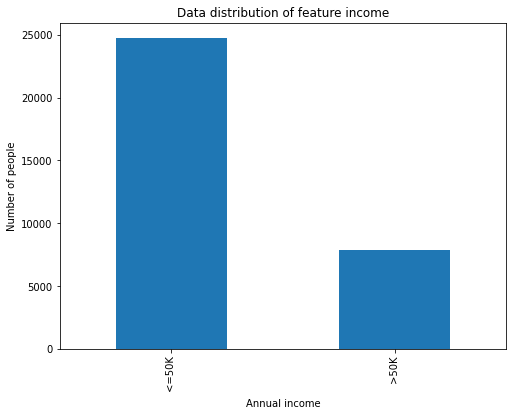

In [ ]:
var='income'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts().plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of people')
ax.set_xlabel('Annual income')
ax.set_xticklabels(labels=[' <=50K', ' >50K'])

###**Feature *age*** 

>Distribution of data values:\
**count:**    32561\
**null:**     0\
**mean:**     38.58 years\
**std:**      13.64 years\
**min:**      17 years\
**25%:**      28 years\
**50%:**      37 years\
**75%:**      48 years\
**max:**      90 years

* Numerical feature with values ranging from 17 to 90 years.

* No missing or null data.

* Unbalanced data distribuiton, with greater concentration of people aged between 20 and 48 years.

* Age values present an average of 38.58 years and median of 37 years.

* 25% of people are under 28 years old and 75% of people have less than 48 years old.

* Regarding the relationship between ages and incomes, we note that older people tend to make over $\$50K$ a year, whereas younger people tend to make less or equal to $\$50K/yr$.

* However, there is an intersection between the boxplots, where we notice that some older people make less money a year than youngers, and vice versa. It shows the relevance of other features to the problem.

* We also note some outliers in both classes regarding ages higher than $\approx$ 75 years.

Distribution of data values of feature age:
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

Percentage of data distribution of feature age:
36    0.027579
31    0.027272
34    0.027210
23    0.026934
35    0.026903
        ...   
83    0.000184
85    0.000092
88    0.000092
87    0.000031
86    0.000031
Name: age, Length: 73, dtype: float64

Total unique values of feature age: 73



count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

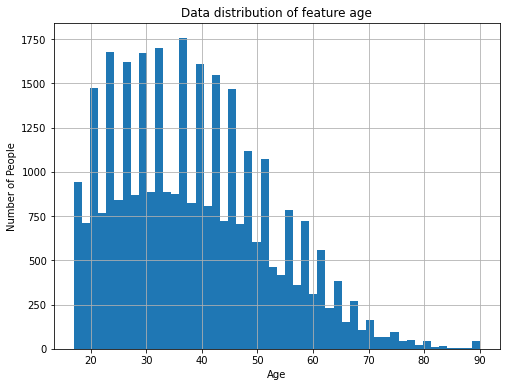

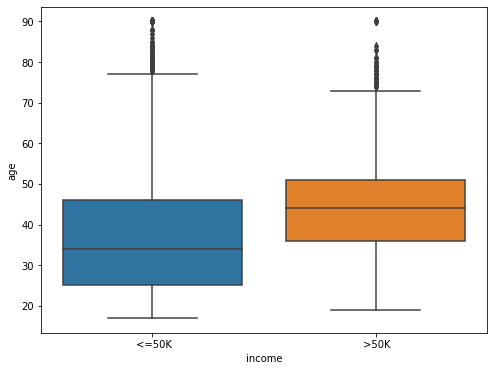

In [ ]:
var='age'
continuous_feature_analysis(train_data, var)

ax=train_data[var].hist(bins=50)
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Age')
plt.show()

sns.boxplot(y='age', x='income', data=train_data)
plt.show()

###**Feature *fnlwgt*** 
> It represents the estimated final weight of each person assigned by the Census Bureau. The weight means that if two samples share similar fnlwgt, they also share similar characteristics.

* Numerical feature with large scale values, and almost a distinct value to each person.

* No missing or null data.

* Regarding the relationship between features fnlwgt and income, we note that the boxplots for both classes of the target feature regarding the data distribution of fnlwgt did not show notable differences.

* This may indicate that fnlwgt is not so useful for the model.

* We also note outliers in both classes of the target regarding the values of fnlwgt.

Distribution of data values of feature fnlwgt:
164190    13
203488    13
123011    13
113364    12
121124    12
          ..
284211     1
312881     1
177711     1
179758     1
229376     1
Name: fnlwgt, Length: 21648, dtype: int64

Percentage of data distribution of feature fnlwgt:
164190    0.000399
203488    0.000399
123011    0.000399
113364    0.000369
121124    0.000369
            ...   
284211    0.000031
312881    0.000031
177711    0.000031
179758    0.000031
229376    0.000031
Name: fnlwgt, Length: 21648, dtype: float64

Total unique values of feature fnlwgt: 21648



count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

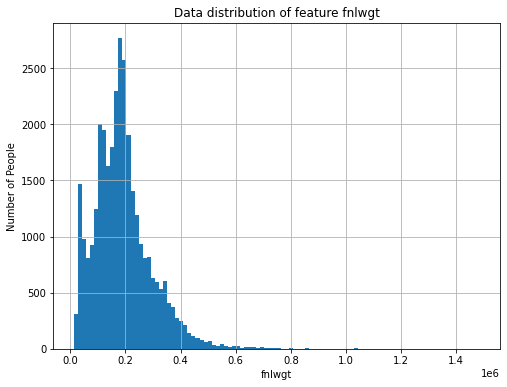

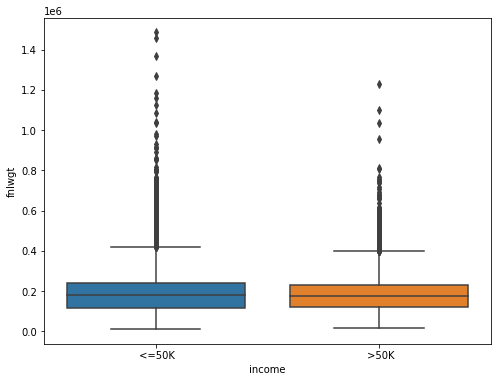

In [ ]:
var='fnlwgt'
continuous_feature_analysis(train_data, var)

ax=train_data[var].hist(bins=100)
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('fnlwgt')
plt.show()

sns.boxplot(y='fnlwgt', x='income', data=train_data)
plt.show()

###**Feature *education*** 

* Categorical feature with 16 distinct categories of education.

* No missing or null data.

* Unbalanced data values, where 32.3% (10501) of people have only the high school graduation (*HS-grad*), followed by 22.4% (7291) of people that have some college degree, and 16.4% (5355) of people that have bachelor's degree.

* This 3 classes together represent 71.1% of the data.

* On the contrary, only 1.27% (413) of people have doctorate degree.

* We note that some classes seem to mean the same education degree, e.g., HS-grad and 9th are related to the high school graduation. Perhaps such classes could be grouped in a single class.

* Regarding the relationship between features education and income:
 * Only 5.14% out of 32.3% of people with HS-grad make over $\$50K/yr$.

 * 4.26% out of 22.4% of people with some college degree make over $\$50K/yr$.

 * 6.82% out of 16.4% of people with bachelors degree make over $\$50K/yr$.
 
 * 0.94% out of 1.27% of people with doctorate degree make over $\$50K/yr$.

 * Such relation may indicate that people with higher level education are more likely to make over $\$50K/yr$ when compared to other classes, e.g., masters and doctorate degrees (see crosstab). 

Data values by class of feature education:
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

Percentage of data values by class of feature education:
 HS-grad         0.322502
 Some-college    0.223918
 Bachelors       0.164461
 Masters         0.052916
 Assoc-voc       0.042443
 11th            0.036086
 Assoc-acdm      0.032769
 10th            0.028654
 7th-8th         0.019840
 Prof-school     0.017690
 9th             0.015786
 12th            0.013298
 Doctorate       0.012684
 5th-6th         0.010227
 1st-4th         0.005160
 Preschool       0.001566
Name: education, dtype: float64

Unique values of feature education:
[' Bachelors' ' 

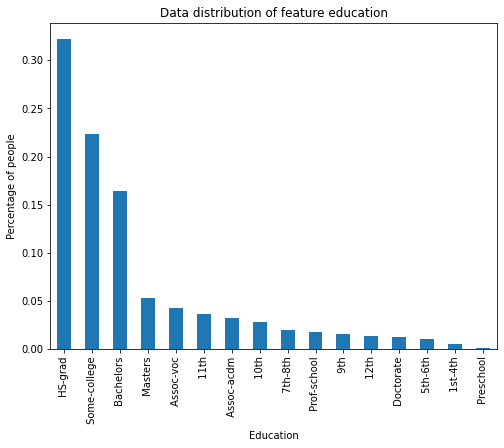

Percentage of people with HS-grad that makes >$50K/yr:  5.144190903227788
Percentage of people with some college degree that makes >$50K/yr:  4.259697183747428
Percentage of people with bachelors that makes >$50K/yr:  6.821043579742637
Percentage of people with doctorate degree that makes >$50K/yr:  0.9397745769478825


income,<=50K,>50K
education,,
10th,0.933548,0.066452
11th,0.948936,0.051064
12th,0.923788,0.076212
1st-4th,0.964286,0.035714
5th-6th,0.951952,0.048048
7th-8th,0.938080,0.061920
9th,0.947471,0.052529
Assoc-acdm,0.751640,0.248360
Assoc-voc,0.738784,0.261216


Text(0, 0.5, 'Percentage of People (normalized by class)')

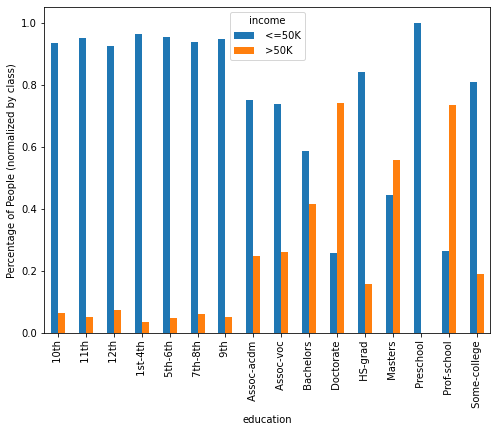

In [ ]:
var='education'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Education')
ax.set_xticklabels(labels=[' HS-grad', ' Some-college', ' Bachelors', ' Masters', ' Assoc-voc', ' 11th', ' Assoc-acdm', ' 10th', ' 7th-8th', ' Prof-school', ' 9th', ' 12th', ' Doctorate', ' 5th-6th', ' 1st-4th', ' Preschool'])
plt.show()

print('Percentage of people with HS-grad that makes >$50K/yr: ', len(train_data[(train_data['education']==' HS-grad') & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people with some college degree that makes >$50K/yr: ', len(train_data[(train_data['education']==' Some-college') & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people with bachelors that makes >$50K/yr: ', len(train_data[(train_data['education']==' Bachelors') & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people with doctorate degree that makes >$50K/yr: ', len(train_data[(train_data['education']==' Doctorate') & (train_data['income']==' >50K')])/len(train_data)*100)

#pd.crosstab([train_data['education'], train_data['workclass']], train_data['income'], normalize='index')
display(pd.crosstab([train_data['education']], train_data['income'], normalize='index'))

pd.crosstab([train_data['education']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *education-num*** 

* Numerical feature with 16 discrete values ranging from 1 to 16 years of education.

* No missing or null data.

* Unbalanced data values, where 32.2% (10501) of people have 9 years of education (equivalent to *HS-grad* of feature education), followed by 22.4% (7291) of people that have 10 years of education (equivalent to some college degree), and 16.4% (5355) of people that have 13 years of education (equivalent to bachelor's degree).

* The considerations about this feature follows the same described in feature education. Thus, one of two features could be disregarded due to redundancy of information.

Distribution of data values of feature education-num:
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education-num, dtype: int64

Percentage of data distribution of feature education-num:
9     0.322502
10    0.223918
13    0.164461
14    0.052916
11    0.042443
7     0.036086
12    0.032769
6     0.028654
4     0.019840
15    0.017690
5     0.015786
8     0.013298
16    0.012684
3     0.010227
2     0.005160
1     0.001566
Name: education-num, dtype: float64

Total unique values of feature education-num: 16



count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education-num, dtype: float64

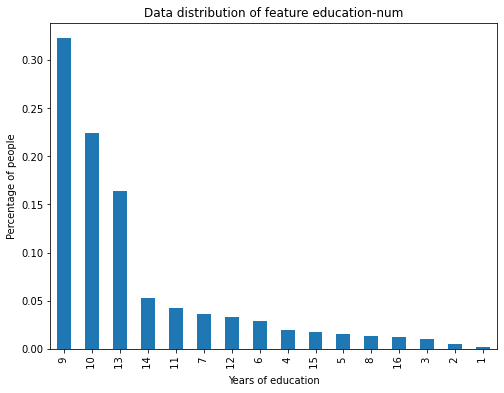

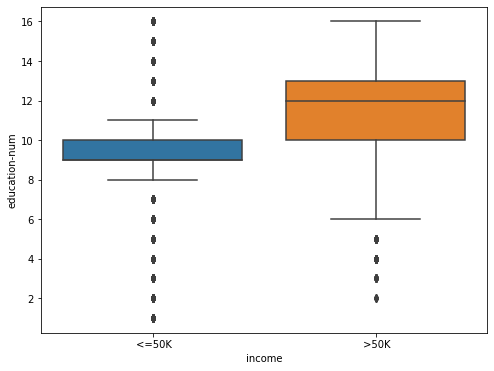

income,<=50K,>50K
education-num,,
1,1.000000,0.000000
2,0.964286,0.035714
3,0.951952,0.048048
4,0.938080,0.061920
5,0.947471,0.052529
6,0.933548,0.066452
7,0.948936,0.051064
8,0.923788,0.076212
9,0.840491,0.159509


Text(0, 0.5, 'Percentage of People (normalized by class)')

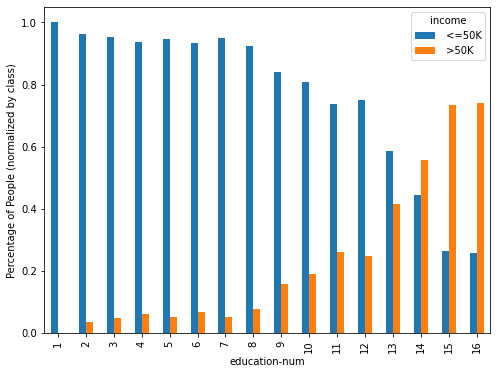

In [ ]:
var='education-num'
continuous_feature_analysis(train_data, var)

ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Years of education')
ax.set_xticklabels(labels=[' 9', ' 10', ' 13', ' 14', ' 11', ' 7', ' 12', ' 6', ' 4', ' 15', ' 5', ' 8', ' 16', ' 3', ' 2', ' 1'])
plt.show()

sns.boxplot(y='education-num', x='income', data=train_data)
plt.show()

#pd.crosstab([train_data['education'], train_data['workclass']], train_data['income'], normalize='index')
display(pd.crosstab([train_data['education-num']], train_data['income'], normalize='index'))

pd.crosstab([train_data['education-num']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *workclass*** 
> It defines each person's work sector.
* Categorical feature with 9 classes.

* No missing or null data. But there is a class *'?'*, which may indicate that the work sector is unknown.

* Unbalanced data values, where 69.7% (22696) of people work in the private sector. The rest of the data is similarly distributed among the other classes, except classes *Without-pay* (14 entries) and *Never-worked* (7 entries).

* Regarding the relationship between features workclass and income:
 * Only 15.24% out of 69.7% of people from the private sector make over $\$50K/yr$.

 * 8.84% out of 30.3% from the other sectors make over $\$50K/yr$.

 * Such relation may indicate that people from the other sectors (not all of them) tend to make over $\$50K/yr$, or at least their work sectors contibute alongside the other features to this end (see crosstab). 
 
 * On the contrary, given the percentages, people from the private sector tend to make less or equal to $\$50K/yr$. We note that other features may support people from this work sector to make over $\$50K/yr$.

Data values by class of feature workclass:
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

Percentage of data values by class of feature workclass:
 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: workclass, dtype: float64

Unique values of feature workclass:
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']



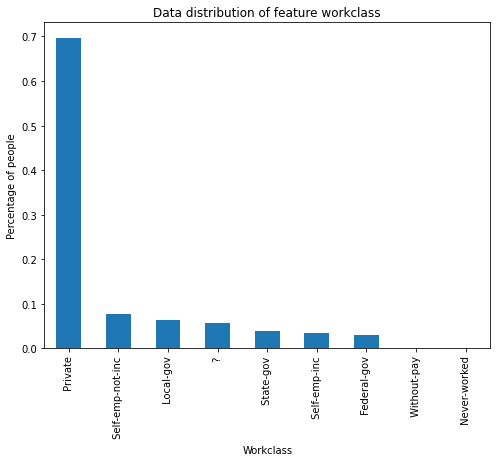

Percentage of people from the private sector that makes >$50K/yr:  15.24216086729523
Percentage of people from the private sector that makes <=$50K/yr:  54.460858081754246
Percentage of people from the other sectors that makes >$50K/yr:  8.838794877307208
Percentage of people from the other sectors that makes <=$50K/yr:  21.458186173643316


income,<=50K,>50K
workclass,,
?,0.895969,0.104031
Federal-gov,0.613542,0.386458
Local-gov,0.705208,0.294792
Never-worked,1.000000,0.000000
Private,0.781327,0.218673
Self-emp-inc,0.442652,0.557348
Self-emp-not-inc,0.715073,0.284927
State-gov,0.728043,0.271957
Without-pay,1.000000,0.000000


Text(0, 0.5, 'Percentage of People (normalized by class)')

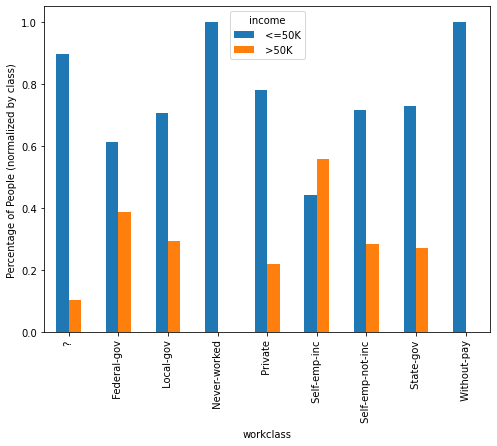

In [ ]:
var='workclass'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Workclass')
ax.set_xticklabels(labels=[' Private', ' Self-emp-not-inc', ' Local-gov', ' ?', ' State-gov', ' Self-emp-inc', ' Federal-gov', ' Without-pay', ' Never-worked'])
plt.show()

print('Percentage of people from the private sector that makes >$50K/yr: ', len(train_data[(train_data['workclass']==' Private') & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people from the private sector that makes <=$50K/yr: ', len(train_data[(train_data['workclass']==' Private') & (train_data['income']==' <=50K')])/len(train_data)*100)
print('Percentage of people from the other sectors that makes >$50K/yr: ', len(train_data[(train_data['workclass']!=' Private') & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people from the other sectors that makes <=$50K/yr: ', len(train_data[(train_data['workclass']!=' Private') & (train_data['income']==' <=50K')])/len(train_data)*100)

display(pd.crosstab([train_data['workclass']], train_data['income'], normalize='index'))

pd.crosstab([train_data['workclass']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *occupation*** 

* Categorical feature with 15 distinct categories of occupation.

* No missing or null data. But there is a class *'?'*, which may indicate that the occupation is unknown.

* Balanced data values for the most populated classes, where the classes Prof-specialty, Craft-repair, Exec-managerial, Adm-clerical, Sales and Other-service include 12.7% (4140), 12.6% (4099), 12.5% (4066), 11.6% (3770), 11.2% (3650) and 10.1%(3295) of people, respectively. 

* These 6 classes encompass 70.7% of the data.

* It's noted that people with professional specialty occupation are more likely to make over $\$50K/yr$ when compared to other categories (see crosstab).

* We note that features education, workclass and occupation are possibly related, e.g., higher education may imply in more specialized positions, and together could help with the income prediction. 

Data values by class of feature occupation:
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

Percentage of data values by class of feature occupation:
 Prof-specialty       0.127146
 Craft-repair         0.125887
 Exec-managerial      0.124873
 Adm-clerical         0.115783
 Sales                0.112097
 Other-service        0.101195
 Machine-op-inspct    0.061485
 ?                    0.056601
 Transport-moving     0.049046
 Handlers-cleaners    0.042075
 Farming-fishing      0.030527
 Tech-support         0.028500
 Protective-serv      0.019932
 Priv-house-serv      0.004576
 Armed-Forces         0.000

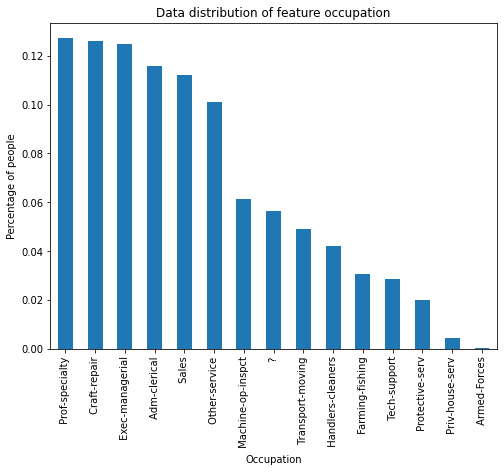

income,<=50K,>50K
occupation,,
?,0.896365,0.103635
Adm-clerical,0.865517,0.134483
Armed-Forces,0.888889,0.111111
Craft-repair,0.773359,0.226641
Exec-managerial,0.515986,0.484014
Farming-fishing,0.884306,0.115694
Handlers-cleaners,0.937226,0.062774
Machine-op-inspct,0.875125,0.124875
Other-service,0.958422,0.041578


Text(0, 0.5, 'Percentage of People (normalized by class)')

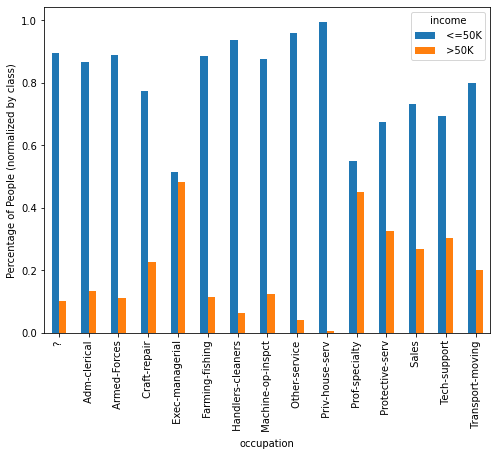

In [ ]:
var='occupation'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Occupation')
ax.set_xticklabels(labels=[' Prof-specialty', ' Craft-repair', ' Exec-managerial', ' Adm-clerical', ' Sales', ' Other-service', ' Machine-op-inspct', ' ?', ' Transport-moving', ' Handlers-cleaners', 
                           ' Farming-fishing', ' Tech-support', ' Protective-serv', ' Priv-house-serv', ' Armed-Forces'])
plt.show()

display(pd.crosstab([train_data['occupation']], train_data['income'], normalize='index'))

pd.crosstab([train_data['occupation']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *marital-status*** 

* Categorical feature with 7 distinct categories of marital status.

* No missing or null data.

* Unbalanced data values, where 45.99% (14976) of people have civilian spouse (Married-civ-spouse), followed by 32.8% (10683) of people that have never been married, and 13.6% (4443) of people that are divorced.

* These 3 classes together represent 92.39% of the data.

* We note that people with civilian spouse (Married-civ-spouse) or with spouse in the Armed Forces (Married-AF-spouse) are more likely to make over $\$50K/yr$ when compared to other categories (see crosstab).

Data values by class of feature marital-status:
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

Percentage of data values by class of feature marital-status:
 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837
 Married-AF-spouse        0.000706
Name: marital-status, dtype: float64

Unique values of feature marital-status:
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']



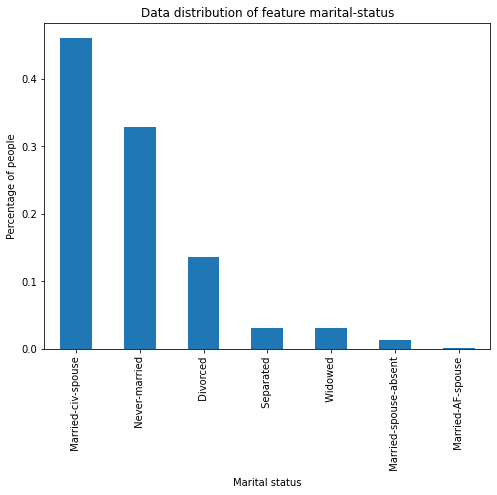

income,<=50K,>50K
marital-status,,
Divorced,0.895791,0.104209
Married-AF-spouse,0.565217,0.434783
Married-civ-spouse,0.553152,0.446848
Married-spouse-absent,0.918660,0.081340
Never-married,0.954039,0.045961
Separated,0.935610,0.064390
Widowed,0.914401,0.085599


Text(0, 0.5, 'Percentage of People (normalized by class)')

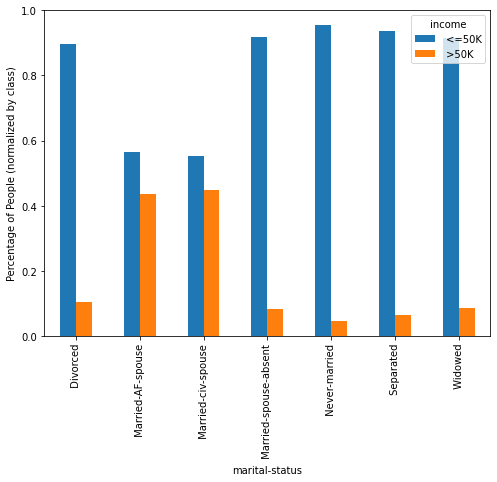

In [ ]:
var='marital-status'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Marital status')
ax.set_xticklabels(labels=[' Married-civ-spouse', ' Never-married', ' Divorced', ' Separated', ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse'])
plt.show()

display(pd.crosstab([train_data['marital-status']], train_data['income'], normalize='index'))

pd.crosstab([train_data['marital-status']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *relationship*** 

* Categorical feature with 6 distinct classes of relationship.

* No missing or null data.

* Unbalanced data values, where 40.5% (13193) of people are the husbands, while only 4.8% (1568) are the wives.

* However, we note that people which are husbands or wives are more likely to make over $\$50K/yr$ when compared to other categories (see crosstab). 

* This corroborates the previous analysis on the feature *marital-status*, where people with civilian spouse (Married-civ-spouse) or with spouse in the Armed Forces (Married-AF-spouse) are more likely to make over $\$50K/yr$ when compared to other categories.

Data values by class of feature relationship:
 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

Percentage of data values by class of feature relationship:
 Husband           0.405178
 Not-in-family     0.255060
 Own-child         0.155646
 Unmarried         0.105832
 Wife              0.048156
 Other-relative    0.030128
Name: relationship, dtype: float64

Unique values of feature relationship:
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']



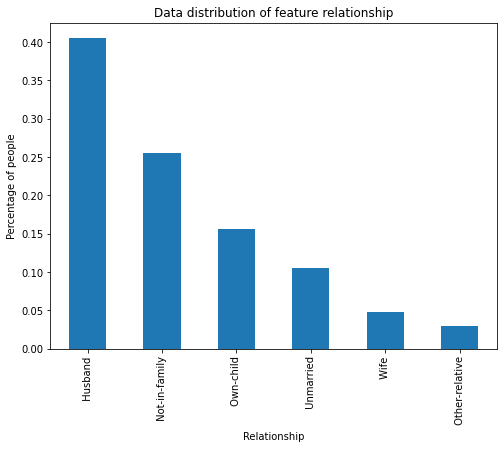

income,<=50K,>50K
relationship,,
Husband,0.551429,0.448571
Not-in-family,0.896930,0.103070
Other-relative,0.962283,0.037717
Own-child,0.986780,0.013220
Unmarried,0.936738,0.063262
Wife,0.524872,0.475128


Text(0, 0.5, 'Percentage of People (normalized by class)')

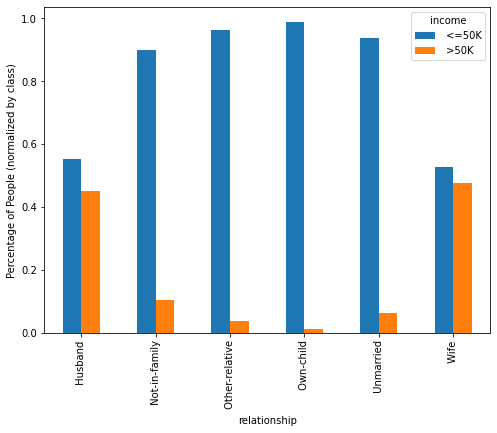

In [ ]:
var='relationship'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Relationship')
ax.set_xticklabels(labels=[' Husband', ' Not-in-family', ' Own-child', ' Unmarried', ' Wife', ' Other-relative'])
plt.show()

display(pd.crosstab([train_data['relationship']], train_data['income'], normalize='index'))

pd.crosstab([train_data['relationship']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *race*** 

* Categorical feature with 5 categories of race.

* No missing or null data.

* Very unbalanced data values, where 85.4% (27816) of people are white, followed by 9.6% (3124) of black people.

* Considering the large number of white people compared to other races, it's not possible to note a clear trend that these people are more likely to make over $\$50K/yr$.

Data values by class of feature race:
 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

Percentage of data values by class of feature race:
 White                 0.854274
 Black                 0.095943
 Asian-Pac-Islander    0.031909
 Amer-Indian-Eskimo    0.009551
 Other                 0.008323
Name: race, dtype: float64

Unique values of feature race:
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']



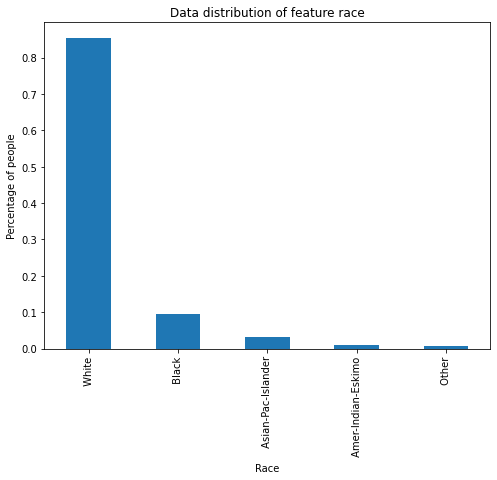

income,<=50K,>50K
race,,
Amer-Indian-Eskimo,0.884244,0.115756
Asian-Pac-Islander,0.734360,0.265640
Black,0.876120,0.123880
Other,0.907749,0.092251
White,0.744140,0.255860


Text(0, 0.5, 'Percentage of People (normalized by class)')

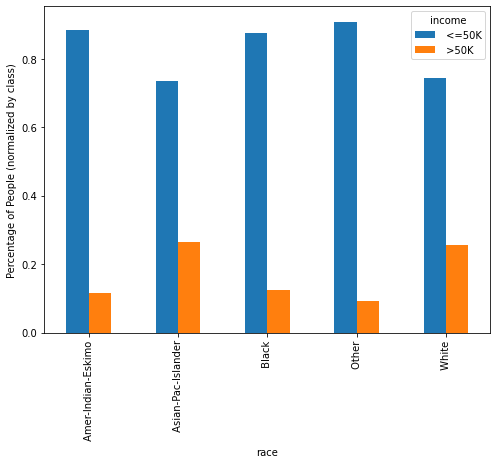

In [ ]:
var='race'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Race')
ax.set_xticklabels(labels=[' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other'])
plt.show()

display(pd.crosstab([train_data['race']], train_data['income'], normalize='index'))

pd.crosstab([train_data['race']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *sex*** 

* Categorical feature with 2 distinct classes.

* No missing or null data.

* Unbalanced data values, where 66.9% (21790) of people are male and 33.1% (10771) of people are female.

* Besides the higher number of male compared to female, we observe that male are more likely to make over $\$50K/yr$ (see crosstab).

Data values by class of feature sex:
 Male      21790
 Female    10771
Name: sex, dtype: int64

Percentage of data values by class of feature sex:
 Male      0.669205
 Female    0.330795
Name: sex, dtype: float64

Unique values of feature sex:
[' Male' ' Female']



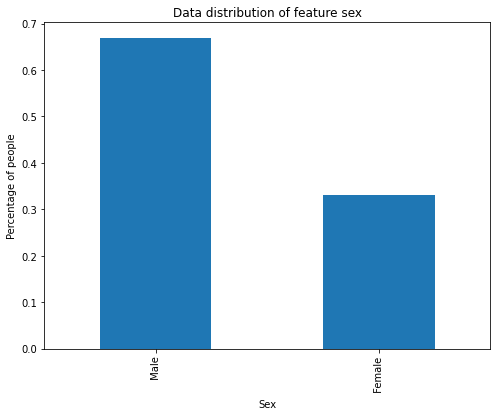

income,<=50K,>50K
sex,,
Female,0.890539,0.109461
Male,0.694263,0.305737


Text(0, 0.5, 'Percentage of People (normalized by class)')

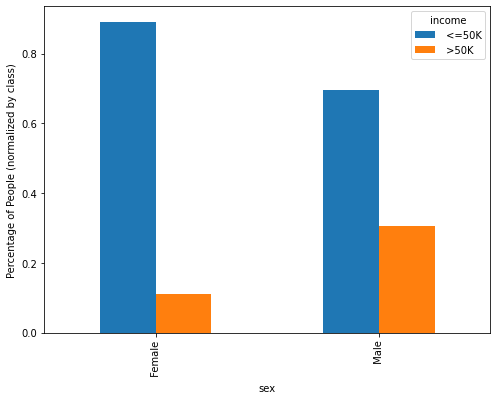

In [ ]:
var='sex'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Sex')
ax.set_xticklabels(labels=[' Male', ' Female'])
plt.show()

display(pd.crosstab([train_data['sex']], train_data['income'], normalize='index'))

pd.crosstab([train_data['sex']], train_data['income'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')

###**Feature *capital-gain*** 
> Capital gain refers to an increase in a capital asset's value and is considered to be realized when the asset is sold.

>Distribution of data values:\
**count:**    32561\
**null:**     0\
**mean:**     \$1077.65\
**std:**      \$7385.29\
**min:**      \$0\
**25%:**      \$0\
**50%:**      \$0\
**75%:**      \$0\
**max:**      \$99999

* Numerical feature with outliers.

* No missing or null data.

* Regarding the relationship between capital gain and annual income, we note that the boxplots for both classes of the target feature regarding the data distribution of capital-gain did not show notable differences.

* Balanced data distribuiton, with greater concentration of people with no capital gain.

* At least 75% of people had no capital gain.

* Both boxplots present outliers regarding this feature.

Distribution of data values of feature capital-gain:
0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital-gain, Length: 119, dtype: int64

Percentage of data distribution of feature capital-gain:
0        0.916710
15024    0.010657
7688     0.008722
7298     0.007555
99999    0.004883
           ...   
4931     0.000031
1455     0.000031
6097     0.000031
22040    0.000031
1111     0.000031
Name: capital-gain, Length: 119, dtype: float64

Total unique values of feature capital-gain: 119



count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

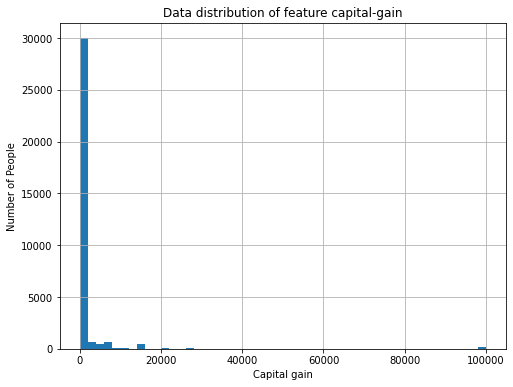

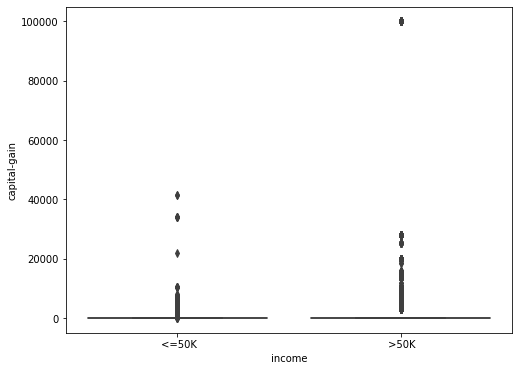

In [ ]:
var='capital-gain'
continuous_feature_analysis(train_data, var)

ax=train_data[var].hist(bins=50)
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Capital gain')
plt.show()

sns.boxplot(y='capital-gain', x='income', data=train_data)
plt.show()

###**Feature *capital-loss*** 
> Capital loss is the loss incurred when a capital asset decreases in value and is considered to be realized when the asset is sold. 

>Distribution of data values:\
**count:**    32561\
**null:**     0\
**mean:**     \$87.30\
**std:**      \$402.96\
**min:**      \$0\
**25%:**      \$0\
**50%:**      \$0\
**75%:**      \$0\
**max:**      \$4356

* Numerical feature with outliers.

* No missing or null data.

* The considerations about this feature follows the previous one.

Distribution of data values of feature capital-loss:
0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital-loss, Length: 92, dtype: int64

Percentage of data distribution of feature capital-loss:
0       0.953349
1902    0.006204
1977    0.005160
1887    0.004883
1848    0.001566
          ...   
1411    0.000031
1539    0.000031
2472    0.000031
1944    0.000031
2201    0.000031
Name: capital-loss, Length: 92, dtype: float64

Total unique values of feature capital-loss: 92



count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64

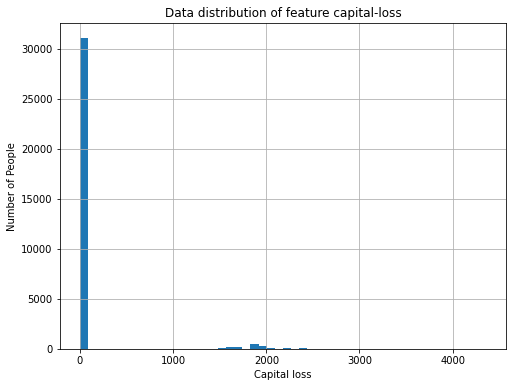

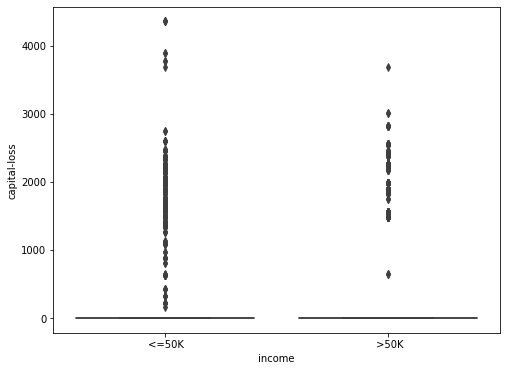

In [ ]:
var='capital-loss'
continuous_feature_analysis(train_data, var)

ax=train_data[var].hist(bins=50)
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Capital loss')
plt.show()

sns.boxplot(y='capital-loss', x='income', data=train_data)
plt.show()

###**Feature *hours-per-week*** 
> Working hours per week.

>Distribution of data values:\
**count:**    32561\
**null:**     0\
**mean:**     40.44 hours\
**std:**      12.35 hours\
**min:**      1 hour\
**25%:**      40 hours\
**50%:**      40 hours\
**75%:**      45 hours\
**max:**      99 hours

* Numerical feature with outliers.

* No missing or null data.

* Unbalanced data distribuiton, with greater concentration of people working between 40 and 45 hours per week.

* The feature hours-per-week presents an average of 40.44 hours and median of 40 hours.

* Regarding the relationship between working hours per week and annual income, we note that people who work more hours per week tend to make over $\$50K$ a year. 

* However, there are cases of people who work more hours per week and make less or equal to $\$50K$ a year, and vice versa.

* We observe that there are outliers in both classes of the target feature regarding the working hours per week, such as 100 hours worked per week.



Distribution of data values of feature hours-per-week:
40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours-per-week, Length: 94, dtype: int64

Percentage of data distribution of feature hours-per-week:
40    0.467338
50    0.086576
45    0.056018
60    0.045300
35    0.039833
        ...   
92    0.000031
94    0.000031
87    0.000031
74    0.000031
82    0.000031
Name: hours-per-week, Length: 94, dtype: float64

Total unique values of feature hours-per-week: 94



count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

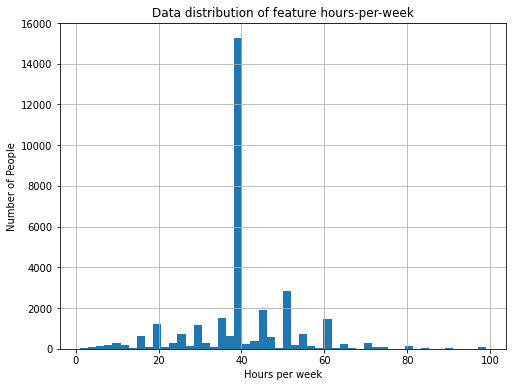

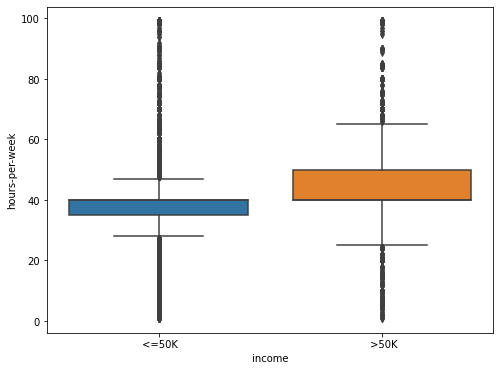

Percentage of people that work less than 40 hours per week and makes >$50K/yr:  2.2665151561684227
Percentage of people that work less than 40 hours per week and makes <=$50K/yr:  21.574890206074752
Percentage of people that work between 40 and 45 hours per week and makes >$50K/yr:  12.659316360062652
Percentage of people that work between 40 and 45 hours per week and makes <=$50K/yr:  41.57427597432511
Percentage of people that work more than 45 hours per week and makes >$50K/yr:  9.155124228371363
Percentage of people that work more than 45 hours per week and makes <=$50K/yr:  12.769878074997695


In [ ]:
var='hours-per-week'
continuous_feature_analysis(train_data, var)

ax=train_data[var].hist(bins=50)
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Number of People')
ax.set_xlabel('Hours per week')
plt.show()

sns.boxplot(y='hours-per-week', x='income', data=train_data)
plt.show()

print('Percentage of people that work less than 40 hours per week and makes >$50K/yr: ', len(train_data[(train_data['hours-per-week']<40) & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people that work less than 40 hours per week and makes <=$50K/yr: ', len(train_data[(train_data['hours-per-week']<40) & (train_data['income']==' <=50K')])/len(train_data)*100)
print('Percentage of people that work between 40 and 45 hours per week and makes >$50K/yr: ', len(train_data[((train_data['hours-per-week'] >= 40) & (train_data['hours-per-week'] <= 45)) & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people that work between 40 and 45 hours per week and makes <=$50K/yr: ', len(train_data[((train_data['hours-per-week'] >= 40) & (train_data['hours-per-week'] <= 45)) & (train_data['income']==' <=50K')])/len(train_data)*100)
print('Percentage of people that work more than 45 hours per week and makes >$50K/yr: ', len(train_data[(train_data['hours-per-week'] > 45) & (train_data['income']==' >50K')])/len(train_data)*100)
print('Percentage of people that work more than 45 hours per week and makes <=$50K/yr: ', len(train_data[(train_data['hours-per-week'] > 45) & (train_data['income']==' <=50K')])/len(train_data)*100)

###**Feature *native-country*** 

* Categorical target feature with 42 distinct countries.

* No missing or null data. But there is a class *'?'*, which may indicate that the native country is unknown.

* Very unbalanced data values, where 89.6% (29170) of people were born in the United States.

* Considering the large number of people that were born in the United States compared to other countries, it's not possible to note a clear trend that these people are more likely to make over $\$50K/yr$.

Data values by class of feature native-country:
 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                 

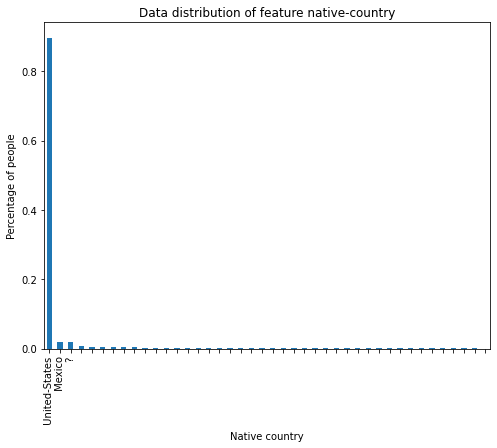

income,<=50K,>50K
native-country,,
?,0.749571,0.250429
Cambodia,0.631579,0.368421
Canada,0.677686,0.322314
China,0.733333,0.266667
Columbia,0.966102,0.033898
Cuba,0.736842,0.263158
Dominican-Republic,0.971429,0.028571
Ecuador,0.857143,0.142857
El-Salvador,0.915094,0.084906


In [ ]:
var='native-country'
categorical_feature_analysis(train_data, var)

##plot distribution
ax=train_data[var].value_counts(normalize=True).plot.bar()
ax.set_title('Data distribution of feature '+var)
ax.set_ylabel('Percentage of people')
ax.set_xlabel('Native country')
ax.set_xticklabels(labels=[' United-States', ' Mexico', ' ?'])
plt.show()

pd.crosstab([train_data['native-country']], train_data['income'], normalize='index')

# **Relation between features**

**Relation between features sex, race, income and numerical ones:**

* On average, it's possible to note that regardless sex and race, people who are older, have a higher education level, had greater capital gains and work more hours per week tend to make over $\$50K/yr$ when compared to others.

* This corroborates our previous analysis.

In [ ]:
display(train_data.groupby(['sex', 'race', 'income']).mean())

age  ...  hours-per-week
sex     race                income             ...                
 Female  Amer-Indian-Eskimo  <=50K  36.906542  ...       35.803738
                             >50K   39.000000  ...       43.500000
         Asian-Pac-Islander  <=50K  34.227723  ...       37.138614
                             >50K   41.162791  ...       39.558140
         Black               <=50K  37.624573  ...       36.491468
                             >50K   41.588889  ...       42.411111
         Other               <=50K  31.388350  ...       35.514563
                             >50K   36.666667  ...       43.000000
         White               <=50K  36.073155  ...       35.764513
                             >50K   42.281128  ...       40.238327
 Male    Amer-Indian-Eskimo  <=50K  36.803571  ...       41.708333
                             >50K   40.041667  ...       45.625000
         Asian-Pac-Islander  <=50K  37.289130  ...       39.273913
                             >50K   42.596567  ...       45.802575
         Black               <=50K  36.124214  ...       38.834119
                             >50K   44.356902  ...       44.979798
         Other               <=50K  33.552448  ...       41.363636
                             >50K   42.947368  ...       45.526316
         White               <=50K  37.285136  ...       40.904241
                             >50K   44.739859  ...       46.460831

[20 rows x 6 columns]

**Relation between features workclass, occupation, income and numerical ones:**

* On average, it's possible to note the same behavior of the other features analayzed above. 

* In general, people who are older, have a higher education level, had greater capital gains and work more hours per week tend to make over $\$50K/yr$ when compared to others.

In [ ]:
display(train_data.groupby(['workclass', 'income']).mean())

age  ...  hours-per-week
workclass         income             ...                
 ?                 <=50K  39.258359  ...       31.428571
                   >50K   55.617801  ...       36.146597
 Federal-gov       <=50K  40.624788  ...       40.093379
                   >50K   45.711590  ...       43.420485
 Local-gov         <=50K  40.704607  ...       39.739837
                   >50K   44.254457  ...       43.956240
 Never-worked      <=50K  20.571429  ...       28.428571
 Private           <=50K  35.113404  ...       38.802290
                   >50K   42.815233  ...       45.500907
 Self-emp-inc      <=50K  43.206478  ...       47.135628
                   >50K   48.249196  ...       50.154341
 Self-emp-not-inc  <=50K  44.388553  ...       43.517336
                   >50K   46.428177  ...       46.691989
 State-gov         <=50K  37.279365  ...       37.105820
                   >50K   45.209632  ...       44.186969
 Without-pay       <=50K  47.785714  ...       32.714286

[16 rows x 6 columns]

In [ ]:
display(train_data.groupby(['occupation', 'income']).mean())

age  ...  hours-per-week
occupation         income             ...                
 ?                  <=50K  39.179177  ...       31.415860
                    >50K   55.617801  ...       36.146597
 Adm-clerical       <=50K  35.987128  ...       37.032485
                    >50K   43.254438  ...       40.942801
 Armed-Forces       <=50K  28.250000  ...       40.750000
                    >50K   46.000000  ...       40.000000
 Craft-repair       <=50K  37.659621  ...       41.607256
                    >50K   43.712594  ...       44.682454
 Exec-managerial    <=50K  39.609152  ...       42.810772
                    >50K   44.898374  ...       47.308435
 Farming-fishing    <=50K  40.445961  ...       46.045506
                    >50K   47.060870  ...       54.208696
 Handlers-cleaners  <=50K  31.462617  ...       37.626947
                    >50K   42.662791  ...       42.732558
 Machine-op-inspct  <=50K  37.048516  ...       40.383562
                    >50K   42.388000  ...       43.364000
 Other-service      <=50K  34.664661  ...       34.339455
                    >50K   41.518248  ...       43.051095
 Priv-house-serv    <=50K  41.689189  ...       32.871622
                    >50K   47.000000  ...       35.000000
 Prof-specialty     <=50K  37.942569  ...       40.110478
                    >50K   43.677246  ...       45.179666
 Protective-serv    <=50K  37.705479  ...       41.579909
                    >50K   41.545024  ...       45.549763
 Sales              <=50K  34.780277  ...       38.329959
                    >50K   44.336724  ...       47.431333
 Tech-support       <=50K  34.355039  ...       38.556589
                    >50K   43.102473  ...       41.427562
 Transport-moving   <=50K  39.120595  ...       43.624902
                    >50K   44.496875  ...       48.771875

[30 rows x 6 columns]

# **Feature engineering**

###**Categorical features**
> Performed operations:

  1. Transformation of categorical features with 2 classes to binary features: *income* and *sex*.

  2. From feature workclass: Creation of feature workclass_simple from the combination of 2 similar classes (Without-pay and Never-worked) with few data in a single one. The other classes remain the same. Other possible solution is to group the gov sectors in a single class.

  3. From feature occupation: Creation of feature occupation_simple from the combination of 2 similar classes ('?' and Other-service) added to the class Armed-Forces with few data. The other classes remain the same.

  4. From feature marital-status: Creation of feature marital-status_simple from the combination of 2 similar classes (Married-civ-spouse and Married-AF-spouse) in a single one, class Never-married, and the abstraction of all other similar classes in only one class (No-spouse).
  
  5. From feature relationship: Creation of feature relationship_simple from the combination of 2 similar classes (Husband and Wife) in a single one. The other classes remain the same.

  6. From feature race: Creation of feature race_simple from the combination of all classes distinct from class White in a single one. Such abstraction was done due to the large number of data in the classe White.
  
  7. From feature native-country: Creation of feature native-country_simple from the abstraction of countries on continents. Creation of 5 classes: the class United-States which remains the same due to the large number of data, America, Europe, Asia and '?'. Other possible solution is to group all countries distinct from the US in a single class.

  8. Transformation of categorical features to numerical features through *one-hot-encoding* strategy.

  * We note that these feature operations (creation, transformation and abstraction of features and classes) are performed in an attempt to support the ML models on the learning phase.

In [ ]:
##categorical features
train_data=pd.get_dummies(train_data, columns=['income', 'sex'], drop_first=True) #binary transformation
test_data=pd.get_dummies(test_data, columns=['income', 'sex'], drop_first=True) #binary transformation

def group_workclass(val):
  #combination of similar classes with few data
  if val==' Without-pay' or val==' Never-worked':            
    return ' WO_pay'
  else:
    return val

def group_occupation(val):
  #combination of similar classes and with few data
  if val==' Armed-Forces' or val==' ?' or val==' Other-service':       
    return ' Other-service'
  else:
    return val

def group_marital_status(val):
  #combination of similar classes
  if val==' Married-civ-spouse' or val==' Married-AF-spouse':       
    return ' Married'
  elif val==' Never-married':
    return val
  else:
    return ' No-spouse'

def group_relationship(val):
  #combination of similar classes
  if val==' Husband' or val==' Wife':       
    return ' Spouse'
  else:
    return val

def group_race(val):
  #combination of classes with few data
  if val==' White':       
    return val
  else:
    return ' Other'

def group_native_country(val):
  #abstraction of classes
  if val==' United-States':       
    return val
  elif val in [' Mexico', ' Cuba', ' Jamaica', ' Puerto-Rico', ' Honduras', ' Columbia', ' Ecuador', ' Guatemala', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Nicaragua', ' Haiti', 
               ' Dominican-Republic', ' El-Salvador', ' Trinadad&Tobago', ' South']:
    return ' America'
  elif val in [' England', ' Canada', ' Germany', ' Italy', ' Poland',  ' Portugal', ' France', ' Greece',  ' Ireland', ' Hungary', ' Yugoslavia', ' Holand-Netherlands', 
               ' Scotland']:
    return ' Europe'
  elif val in [' India', ' Philippines', ' Iran', ' Cambodia', ' Thailand', ' Laos', ' Taiwan', ' China', ' Japan', ' Vietnam', ' Hong']:
    return ' Asia'
  else:
    return ' ?'

##creation of new features from the combination and abstraction of existing classes
train_data['workclass_simple']=train_data['workclass'].map(group_workclass)
train_data['occupation_simple']=train_data['occupation'].map(group_occupation)
train_data['marital-status_simple']=train_data['marital-status'].map(group_marital_status)
train_data['relationship_simple']=train_data['relationship'].map(group_relationship)
train_data['race_simple']=train_data['race'].map(group_race)
train_data['native-country_simple']=train_data['native-country'].map(group_native_country)

train_data=pd.get_dummies(train_data, columns=['workclass_simple', 'occupation_simple', 'marital-status_simple', 'relationship_simple', 'race_simple', 'native-country_simple'], drop_first=True)

##test dataset
test_data['workclass_simple']=test_data['workclass'].map(group_workclass)
test_data['occupation_simple']=test_data['occupation'].map(group_occupation)
test_data['marital-status_simple']=test_data['marital-status'].map(group_marital_status)
test_data['relationship_simple']=test_data['relationship'].map(group_relationship)
test_data['race_simple']=test_data['race'].map(group_race)
test_data['native-country_simple']=test_data['native-country'].map(group_native_country)

test_data=pd.get_dummies(test_data, columns=['workclass_simple', 'occupation_simple', 'marital-status_simple', 'relationship_simple', 'race_simple', 'native-country_simple'], drop_first=True)

###**Numerical features**
> Performed operations:

1. From features capital-gain and capital-loss: Creation of a binary feature *has_assets* that indicates if a person has any type of asset based on its capital gain or loss.

2. Adaptive binning based on the quartiles of features age and hours-per-week. Binning is used to categorize (smooth) continuous values. Two new features were created.

3. Standardization of numerical features age, fnlwgt, education-num, capital-gain, capital-loss and hours-per-week.

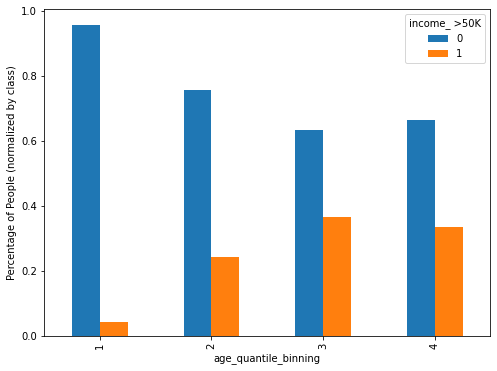

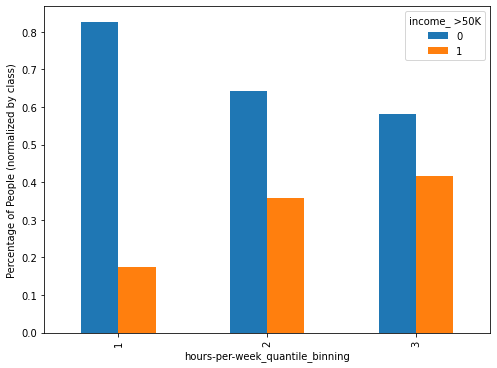

In [ ]:
##numerical features
#train_data=train_data[(np.abs(stats.zscore(train_data['age'])) < 3)]] #removal of outliers

##binary feature for assets
train_data['has_asset']=(train_data['capital-gain'] > 0) | (train_data['capital-loss'] > 0)
train_data['has_asset']=train_data['has_asset'].astype(int)
#display(train_data['has_asset'])

test_data['has_asset']=(test_data['capital-gain'] > 0) | (test_data['capital-loss'] > 0)
test_data['has_asset']=test_data['has_asset'].astype(int)

##binning of feature age based on quartiles
quantile_list=[0, .25, .5, .75, 1.]
quantiles=train_data['age'].quantile(quantile_list)
train_data['age_quantile_binning']=pd.qcut(train_data['age'], q=quantile_list, labels=[1, 2, 3, 4]).astype(int)
#display(train_data['age_quantile_binning'])
pd.crosstab([train_data['age_quantile_binning']], train_data['income_ >50K'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')
plt.show()

test_data['age_quantile_binning']=pd.qcut(test_data['age'], q=quantile_list, labels=[1, 2, 3, 4]).astype(int) #binning test dataset based on the train dataset

##binning of feature hour-per-week based on quantiles
quantile_list=[0, .25, .5, .75, 1.]
quantiles=train_data['hours-per-week'].quantile(quantile_list)
train_data['hours-per-week_quantile_binning']=pd.qcut(train_data['hours-per-week'], q=quantile_list, labels=[1, 2, 3], duplicates='drop').astype(int) #2 quartiles are the same
#display(train_data['hours-per-week_quantile_binning'])
pd.crosstab([train_data['hours-per-week_quantile_binning']], train_data['income_ >50K'], normalize='index').plot.bar()
plt.ylabel('Percentage of People (normalized by class)')
plt.show()

test_data['hours-per-week_quantile_binning']=pd.qcut(test_data['hours-per-week'], q=quantile_list, labels=[1, 2, 3], duplicates='drop').astype(int) #binning test dataset based on train dataset

norm_features=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
#train_data=std_features_all(train_data, norm_features)
train_data, test_data=std_features(train_data, test_data, norm_features) #std scalar train and test data (based on train data)

#train_data.describe()
#test_data.describe()

# **Correlation between features**

* We note that any feature presents correlation from moderate to high (abs(corr) > 0.5) regarding the target feature.

* However, considering scenarios of correlation from moderate to high (0.5 < abs(corr) <= 1.0), the following features have some correlation:
  * 'age', 'age_quantile_binning': 0.94
  * 'age', 'marital-status_simple_ Never-married': -0.54
  * 'capital-loss', 'has_asset': 0.56
  * 'hours-per-week', 'hours-per-week_quantile_binning': 0.71
  * 'marital-status_simple_ Never-married', 'age_quantile_binning': -0.55
  * 'marital-status_simple_ Never-married', 'relationship_simple_ Own-child': 0.51
  * 'marital-status_simple_ Never-married', 'relationship_simple_ Spouse'): -0.64
  * 'native-country_simple_ America', 'native-country_simple_ United-States': -0.64

* In general, we observe that the features of the dataset don't present strong correlated scenarios, except for the binning features that will not be used alongside the originals. 

{('age', 'age_quantile_binning'): 0.9370601085371678,
 ('age', 'marital-status_simple_ Never-married'): -0.5343589501266734,
 ('capital-loss', 'has_asset'): 0.5606341717654844,
 ('hours-per-week', 'hours-per-week_quantile_binning'): 0.7108082811904041,
 ('marital-status_simple_ Never-married',
  'age_quantile_binning'): -0.5541794719972704,
 ('marital-status_simple_ Never-married',
  'relationship_simple_ Own-child'): 0.5092257929610724,
 ('marital-status_simple_ Never-married',
  'relationship_simple_ Spouse'): -0.6363421546833224,
 ('native-country_simple_ America',
  'native-country_simple_ United-States'): -0.6434017636797649}

{}


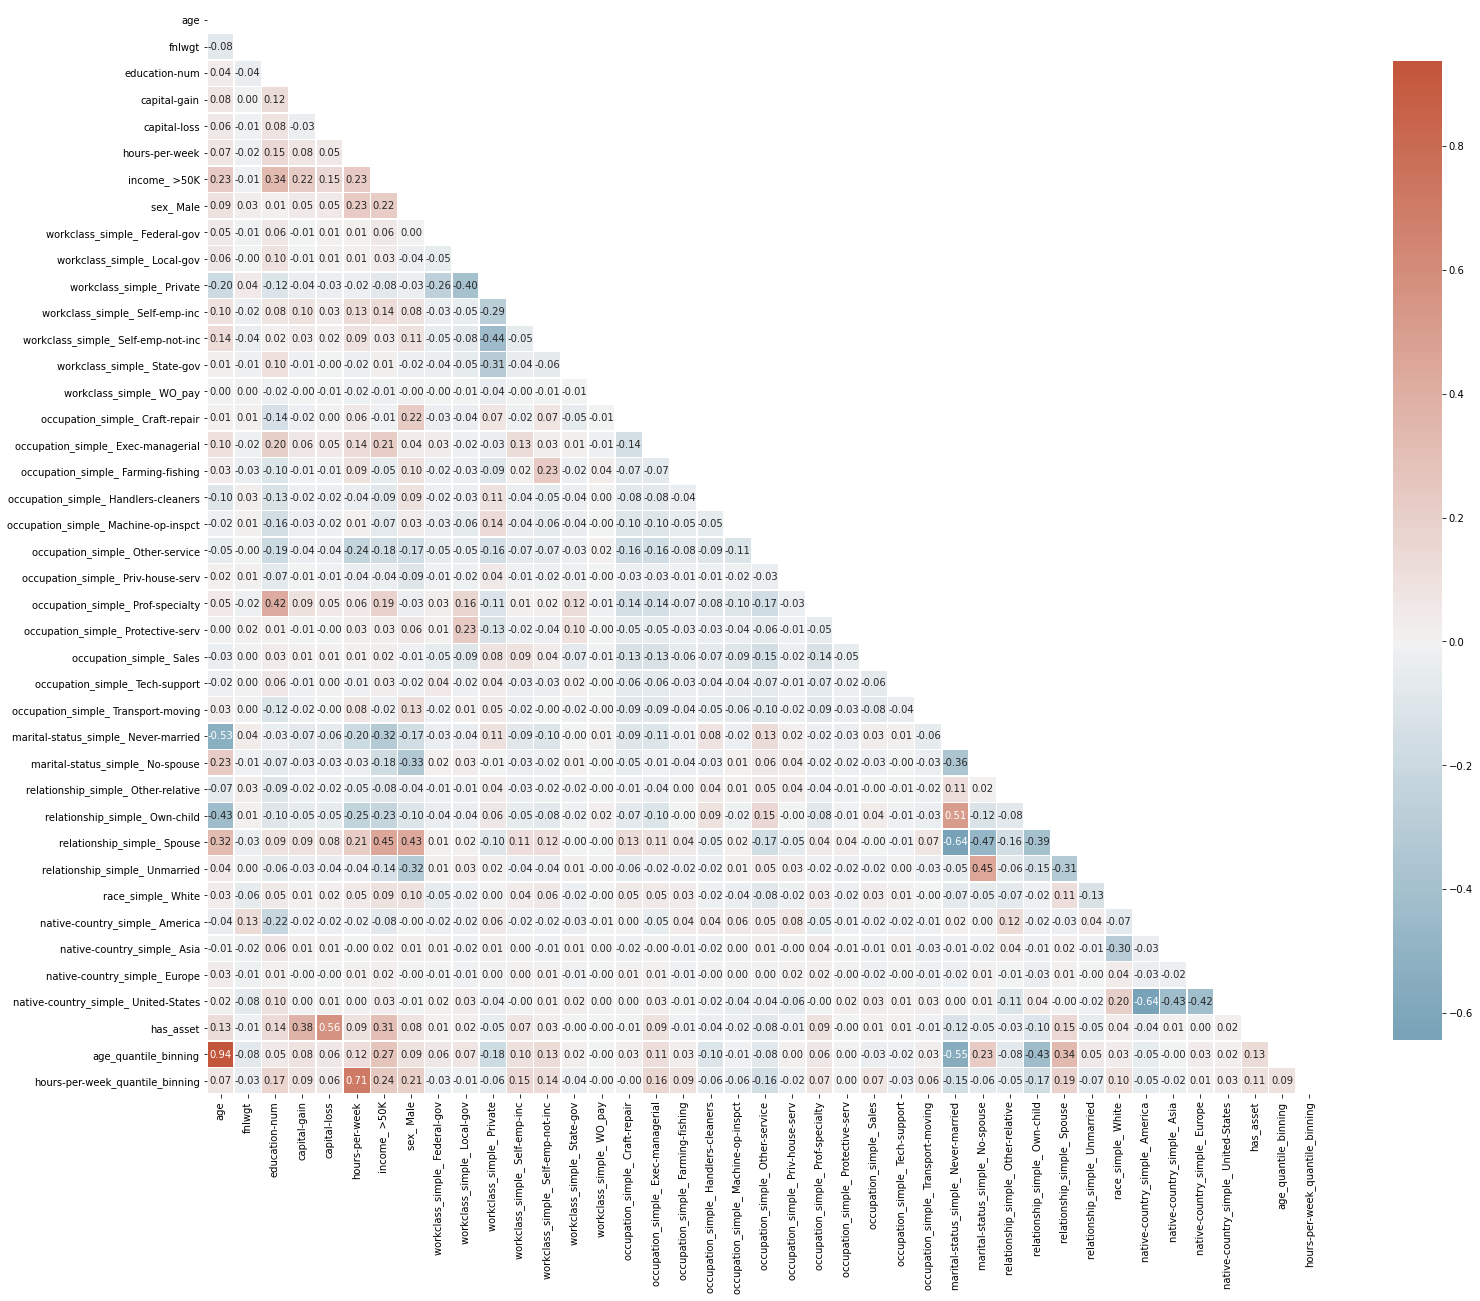

In [ ]:
corr=train_data.iloc[:, :].corr()
#display(corr)

dict_corr=get_correlations(corr, corr_threshold=0.5) #dict with the highest abs correlations between all dataset features
display(dict_corr)

features_to_consider={} #dict with features correlated to the target, such as abs(corr)>0.5
for index, value in dict_corr.items():
      if index[0]=='income_ >50K':
        try:
          features_to_consider[index[1]].append(value)
        except:
          features_to_consider[index[1]]=[value]
      elif index[1]=='income_ >50K':
        try:
          features_to_consider[index[0]].append(value)
        except:
          features_to_consider[index[0]]=[value]

print(features_to_consider)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .9}, annot=True, fmt='.2f')

# **ML steps**

**Prediction problem:**

The prediction task is to determine whether a person makes over $\$50K$ a year (income exceeds $\$50K/yr$) based on census data.

**Features to the ML models:**

X = train features\
y = target feature

### **Train Definition I**

* **Test 1)** Firstly, almost all features of the dataset will be used, except the target feature and the created ones (binning features). But the features that were simplified in terms of similarity of classes and amount of data will be included (via one-hot-encoding).

In [ ]:
print(train_data.columns)

features=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
       'has_asset',
       'sex_ Male', 
       'workclass_simple_ Federal-gov',
       'workclass_simple_ Local-gov', 
       'workclass_simple_ Private',
       'workclass_simple_ Self-emp-inc', 
       'workclass_simple_ Self-emp-not-inc',
       'workclass_simple_ State-gov',
       'workclass_simple_ WO_pay',
       'occupation_simple_ Craft-repair', 
       'occupation_simple_ Exec-managerial',
       'occupation_simple_ Farming-fishing',
       'occupation_simple_ Handlers-cleaners',
       'occupation_simple_ Machine-op-inspct',
       'occupation_simple_ Other-service',
       'occupation_simple_ Priv-house-serv',
       'occupation_simple_ Prof-specialty',
       'occupation_simple_ Protective-serv', 
       'occupation_simple_ Sales',
       'occupation_simple_ Tech-support',
       'occupation_simple_ Transport-moving',
       'marital-status_simple_ Never-married',
       'marital-status_simple_ No-spouse',
       'relationship_simple_ Other-relative', 
       'relationship_simple_ Own-child',
       'relationship_simple_ Spouse', 
       'relationship_simple_ Unmarried',
       'race_simple_ White', 
       'native-country_simple_ America',
       'native-country_simple_ Asia', 
       'native-country_simple_ Europe',
       'native-country_simple_ United-States']

print(len(features))

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income_ >50K',
       'sex_ Male', 'workclass_simple_ Federal-gov',
       'workclass_simple_ Local-gov', 'workclass_simple_ Private',
       'workclass_simple_ Self-emp-inc', 'workclass_simple_ Self-emp-not-inc',
       'workclass_simple_ State-gov', 'workclass_simple_ WO_pay',
       'occupation_simple_ Craft-repair', 'occupation_simple_ Exec-managerial',
       'occupation_simple_ Farming-fishing',
       'occupation_simple_ Handlers-cleaners',
       'occupation_simple_ Machine-op-inspct',
       'occupation_simple_ Other-service',
       'occupation_simple_ Priv-house-serv',
       'occupation_simple_ Prof-specialty',
       'occupation_simple_ Protective-serv', 'occupation_simple_ Sales',
       'occupation_simple_ Tech-support',
       'occupation_simple_ Transport-moving',
  

In [ ]:
X = train_data[features]
y = train_data['income_ >50K']
display(X.head())
display(y.head())

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,has_asset,sex_ Male,workclass_simple_ Federal-gov,workclass_simple_ Local-gov,workclass_simple_ Private,workclass_simple_ Self-emp-inc,workclass_simple_ Self-emp-not-inc,workclass_simple_ State-gov,workclass_simple_ WO_pay,occupation_simple_ Craft-repair,occupation_simple_ Exec-managerial,occupation_simple_ Farming-fishing,occupation_simple_ Handlers-cleaners,occupation_simple_ Machine-op-inspct,occupation_simple_ Other-service,occupation_simple_ Priv-house-serv,occupation_simple_ Prof-specialty,occupation_simple_ Protective-serv,occupation_simple_ Sales,occupation_simple_ Tech-support,occupation_simple_ Transport-moving,marital-status_simple_ Never-married,marital-status_simple_ No-spouse,relationship_simple_ Other-relative,relationship_simple_ Own-child,relationship_simple_ Spouse,relationship_simple_ Unmarried,race_simple_ White,native-country_simple_ America,native-country_simple_ Asia,native-country_simple_ Europe,native-country_simple_ United-States
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


0    0
1    0
2    0
3    0
4    0
Name: income_ >50K, dtype: uint8

### **Data split: train and validation**



In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, stratify=y, random_state=376) #test_size=0.2, 0.3
print(train_X.head())
print(train_y.head())

            age  ...  native-country_simple_ United-States
27780 -0.042642  ...                                     1
12350 -0.482518  ...                                     1
12202 -0.629143  ...                                     1
5735  -1.362269  ...                                     1
31399 -0.775768  ...                                     1

[5 rows x 38 columns]
27780    1
12350    0
12202    1
5735     0
31399    0
Name: income_ >50K, dtype: uint8


### **ML models**

**Datasets:**

> Train: train_X, train_y\
> Validation: val_X, val_y\
> Test: X_test, y_test

### **DummyClassifier algorithm: Baseline**

The *most frequent* strategy are used: given the most frequent value of the target feature, the baseline will infer that all entries in the dataset assume this value in the prediction step.

> **The DummyClassifier achieved 0.76 of accuracy ($\approx$ 76% correct predictions).**

Dummy Classifier prediction | Classification metric:
Accuracy: 0.7592433361994841
Recall: 0.0
Precision: 0.0
F1: 0.0

TN:  6181 FP:  0 FN:  1960 TP:  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


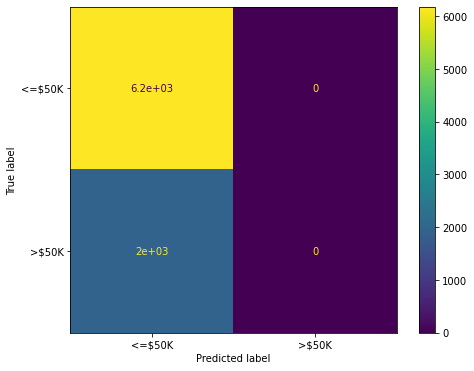

In [ ]:
dummy_model = DummyClassifier('most_frequent', random_state=376)
dummy_model.fit(train_X, train_y)
dummy_prediction = dummy_model.predict(val_X) 
calc_performance_metrics('Dummy Classifier', val_y, dummy_prediction)
calc_confusion_matrix(val_y, dummy_prediction)

### **Logistic Regression algorithm**

> Logistic Regression with max_iter = 1000.

> **The Logistic Regression achieved:**
* 0.85 of accuracy ($\approx$ 85% correct predictions).
* 0.59 of recall (it measures the number of positive class ($>\$50K$) made out of all positive entries in the dataset).
  * We observe that the target feature has unbalanced classes with more data into the negative class ($<=\$50K$), which can bias the model to predict negative values (increase the false negatives). Such scenario can contribute to the recall's reduction. 
* 0.75 of precision (it measures the number of positive class predictions that really belong to the positive class ($>\$50K$)).
  * Contrarily, the precision isn't affected by the bias of predicting more negative values. 
* 0.66 of F1 score (F1 tries to balance both the concerns of precision and recall in a single metric).


Logistic Regression prediction | Classification metric:
Accuracy: 0.8544404864267289
Recall: 0.5948979591836735
Precision: 0.7488760436737315
F1: 0.6630651123116292

TN:  5790 FP:  391 FN:  794 TP:  1166


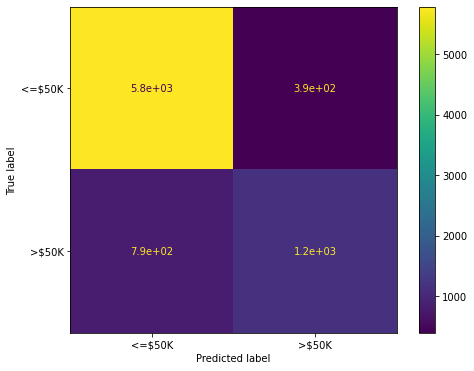

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=376)
lr_model.fit(train_X, train_y) 
lr_prediction=lr_model.predict(val_X)
calc_performance_metrics('Logistic Regression', val_y, lr_prediction)
calc_confusion_matrix(val_y, lr_prediction)

### **Decision Tree algorithm**

> Decision Tree model with a simple optimization to find the max_depth. The function tries to find the best trade-off between fit and validation score (one step before overfitting). 

* **The best scores for both datasets were achieved when max_depth=7.**

* For max_depth=8, we can see the increase in the training score but the decrease in the validation score, i.e., the model is overfitted. 

* Until max_depth=7, the model was lowering the bias and variance, after that, the variance started to increase.

> **The Decision Tree achieved:**
* 0.85 of accuracy ($\approx$ 85% correct predictions).
* 0.53 of recall. 
* 0.79 of precision.
* 0.64 of F1 score.


max_depth: 1 fit score: 0.7591728091728092 validation score: 0.7592433361994841
max_depth: 2 fit score: 0.8296068796068796 validation score: 0.8275396142979978
max_depth: 3 fit score: 0.8453726453726453 validation score: 0.8421569831716006
max_depth: 4 fit score: 0.8478705978705978 validation score: 0.8437538385947673
max_depth: 5 fit score: 0.8569205569205569 validation score: 0.8503869303525365
max_depth: 6 fit score: 0.8599099099099099 validation score: 0.8525979609384596
max_depth: 7 fit score: 0.862940212940213 validation score: 0.8534578061663186
max_depth: 8 fit score: 0.8648648648648649 validation score: 0.8512467755803955
max_depth: 9 fit score: 0.868959868959869 validation score: 0.8497727551897801
max_depth: 10 fit score: 0.8780917280917281 validation score: 0.851001105515293

Decision Tree prediction | Classification metric:
Accuracy: 0.8534578061663186
Recall: 0.5346938775510204
Precision: 0.7885628291948834
F1: 0.6372757677105504

TN:  5900 FP:  281 FN:  912 TP:  1048


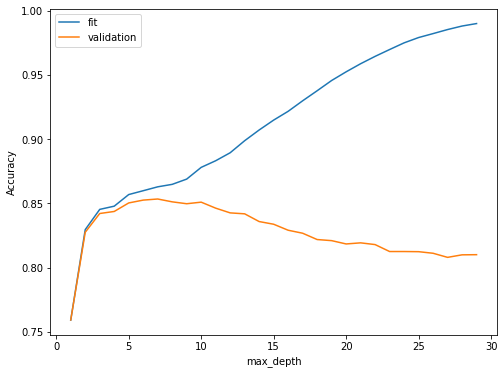

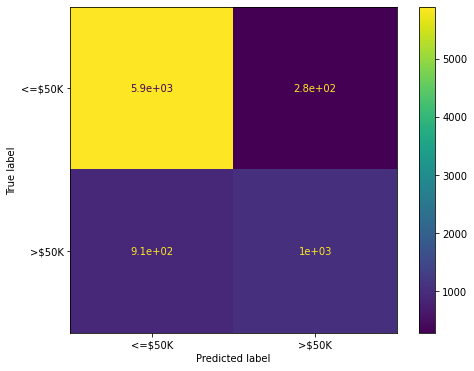

In [ ]:
#simple search to define the max_depth parameter
train=[]
valid=[]
for i in range(1,30):
  dtree_model = DecisionTreeClassifier(max_depth=i, random_state=376)
  dtree_model.fit(train_X, train_y)
  train.append(dtree_model.score(train_X, train_y))
  valid.append(dtree_model.score(val_X, val_y))

for i in range(10):
  print('max_depth:', i+1, 'fit score:', train[i], 'validation score:', valid[i]) #best trade-off between fit and validation score when max_depth=6
print('')

ax=sns.lineplot(x=range(1,30), y = train, label='fit')
ax=sns.lineplot(x=range(1,30), y = valid, label='validation')
ax.set(xlabel='max_depth', ylabel='Accuracy')

dtree_model = DecisionTreeClassifier(max_depth = 7, random_state=376)
dtree_model.fit(train_X, train_y)
dtree_prediction=dtree_model.predict(val_X)
calc_performance_metrics('Decision Tree', val_y, dtree_prediction)
calc_confusion_matrix(val_y, dtree_prediction)

### **Random Forest algorithm**

> Random Forest model with n_estimators=500.

> **The Random Forest achieved:**
* 0.85 of accuracy ($\approx$ 85% correct predictions).
* 0.63 of recall. 
* 0.73 of precision.
* 0.68 of F1 score.

* The most important features for the prediction process were age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week, has_asset, marital-status_simple_ Never-married, relationship_simple_ Spouse.

Random Forest prediction | Classification metric:
Accuracy: 0.8534578061663186
Recall: 0.6209183673469387
Precision: 0.7300539892021596
F1: 0.6710780259167356

TN:  5731 FP:  450 FN:  743 TP:  1217


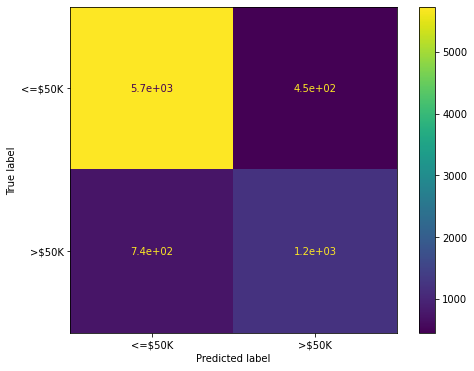

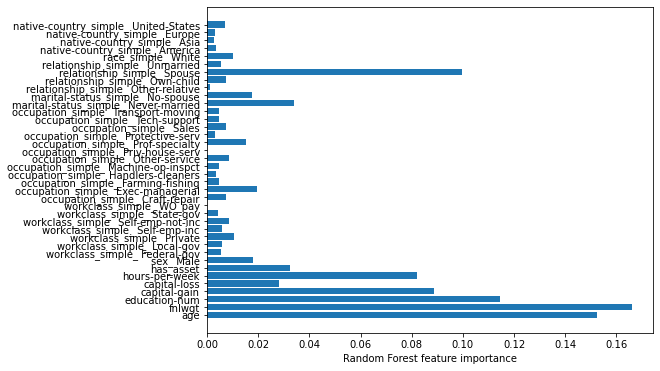

In [ ]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=376)
rf_model.fit(train_X, train_y)
rf_prediction=rf_model.predict(val_X)
calc_performance_metrics('Random Forest', val_y, rf_prediction)
calc_confusion_matrix(val_y, rf_prediction)
plt.show()

plt.barh(features, rf_model.feature_importances_)
plt.xlabel("Random Forest feature importance")
plt.show()

### **XGBoost algorithm**

> XGBoost model with default parameters.

> **The XGBoost achieved:**
* 0.86 of accuracy ($\approx$ 86% correct predictions).
* 0.59 of recall. 
* 0.78 of precision.
* 0.67 of F1 score.

XGBoost prediction | Classification metric:
Accuracy: 0.8594767227613316
Recall: 0.5857142857142857
Precision: 0.7756756756756756
F1: 0.6674418604651163

TN:  5849 FP:  332 FN:  812 TP:  1148


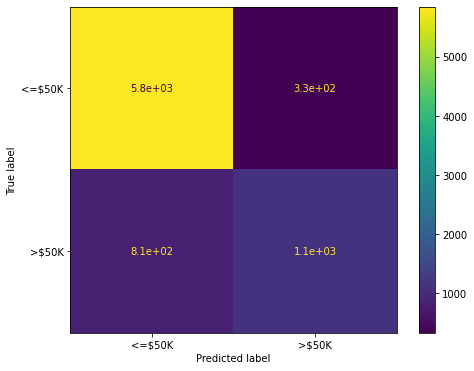

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=376)
xgb_model.fit(train_X, train_y)
xgb_prediction=xgb_model.predict(val_X)
calc_performance_metrics('XGBoost', val_y, xgb_prediction)
calc_confusion_matrix(val_y, xgb_prediction)

### **Randomized search on hyper parameters**

> As all models have reached similar performance scores in terms of accuracy, recall, precision and F1, a hyperparameter optimization will be applied to the Random Forest algorithm in an attempt to improve the obtained performance metrics.

To do that, the RandomizedSearchCV method is used, where one can define a set of hyperparameter ranges, and randomly sample from the set, performing Kfold cross validation with each combination of values.

After the optimization, a cross validation procedure will be performed on the optimized model to ensure the obtained scores. 

> **Best set of parameters: 'n_estimators' = 1240, 'min_samples_split' = 10, 'min_samples_leaf' = 2, 'max_depth' = 50**

> **The optimized Random Forest achieved:**
* 0.86 of accuracy ($\approx$ 86% correct predictions).
* 0.62 of recall. 
* 0.77 of precision.
* 0.69 of F1 score.

**In general, the optimized Random Forest has achieved similar results when compared to the best metrics of the other methods.**

We note that the optimization must be executed for a longer time in order to efficiently explore the solution space.    

{'n_estimators': 1240, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 50}
Random Forest prediction | Classification metric:
Accuracy: 0.8630389387053188
Recall: 0.6214285714285714
Precision: 0.7655562539283469
F1: 0.686003942551394

TN:  5808 FP:  373 FN:  742 TP:  1218


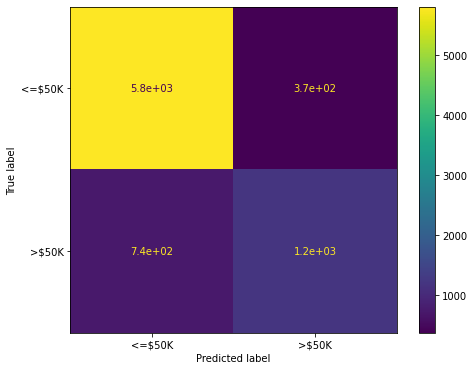

In [ ]:
def optimize_rf_params(train_X, train_y, val_X, val_y):
  ##randomized optimization with cross validation for the hyperparameters of the random forest
  ##return the optimized rf model
  rf_params = {'n_estimators': [int(i) for i in range(100, 2001, 380)], #6 values
            'max_depth': [int(i) for i in range(10, 51, 10)],
            #'max_features' = ['auto', 'log2'],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [2, 4, 6],
            #'bootstrap' = [True, False]
            }
  random_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, cv=4, n_iter=20)
  random_rf.fit(train_X, train_y)

  print(random_rf.best_params_)
  opt_rf_model=random_rf.best_estimator_

  opt_rf_prediction=opt_rf_model.predict(val_X)
  calc_performance_metrics('Random Forest', val_y, opt_rf_prediction)
  calc_confusion_matrix(val_y, opt_rf_prediction)
  return opt_rf_model


opt_rf_model=optimize_rf_params(train_X, train_y, val_X, val_y)


### **Cross Validation: *Kfold***

> The cross validation procedure is applied to the optimized Random Forest model in order to ensure the obtained scores. 

> **The optimized Random Forest through cross validation achieved on Test 1:**
  * Accuracy | mean: 0.866963 | min: 0.860565 | max: 0.871146
  * Recall | mean: 0.621142 | min: 0.600904 | max: 0.639062
  * Precision | mean: 0.781704 | min: 0.759752 | max: 0.798710
  * F1 | mean: 0.692134 | min: 0.678379 | max: 0.702870

**Such results show the predictions consistency.**


ML model prediction | Classification metric:
Accuracy: 0.8658641444539983
Recall: 0.6080041046690611
Precision: 0.783212161269002
F1: 0.6845753899480068


ML model prediction | Classification metric:
Accuracy: 0.8702702702702703
Recall: 0.6285858077503774
Precision: 0.7970644543714104
F1: 0.7028700056274619


ML model prediction | Classification metric:
Accuracy: 0.8642506142506142
Recall: 0.6170984455958549
Precision: 0.7649325626204239
F1: 0.6831086894178376


ML model prediction | Classification metric:
Accuracy: 0.8705159705159705
Recall: 0.6283544303797468
Precision: 0.795003203074952
F1: 0.701923076923077


ML model prediction | Classification metric:
Accuracy: 0.8702862056258445
Recall: 0.6270046559751681
Precision: 0.7834518422753717
F1: 0.696551724137931


ML model prediction | Classification metric:
Accuracy: 0.8675675675675676
Recall: 0.6144702842377261
Precision: 0.7817225509533202
F1: 0.6880787037037037


ML model prediction | Classification metric:
Accuracy: 0.86056511056

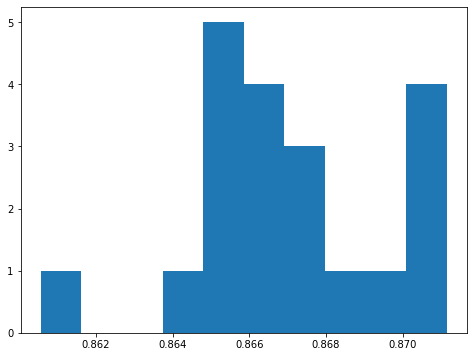

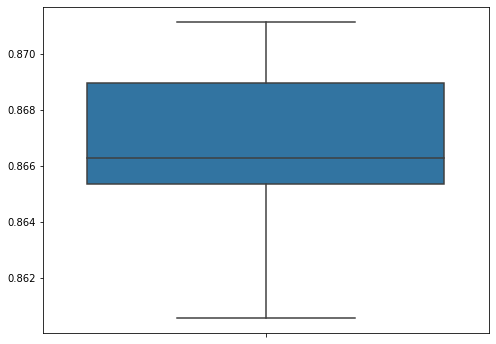

In [ ]:
def cross_validation_prediction(ml_model, X, y):
  list_metrics=[]

  kf=RepeatedKFold(n_splits=4, n_repeats=5, random_state=376)

  train_X, val_X, train_y, val_y=None, None, None, None
  for l_train, l_val in kf.split(X):
    #print(l_train.shape[0], l_val.shape[0])
    train_X, val_X = X.iloc[l_train], X.iloc[l_val]
    train_y, val_y = y.iloc[l_train], y.iloc[l_val]

    ##optimized Random Forest
    #ml_model = RandomForestClassifier(n_estimators=500, random_state=376)
    ml_model.fit(train_X, train_y)
    ml_prediction=ml_model.predict(val_X)
    acc, recall, prec, f1=calc_performance_metrics('ML model', val_y, ml_prediction)

    list_metrics.append([acc, recall, prec, f1])

    #plt.barh(features, ml_model.feature_importances_)
    #plt.xlabel("Random Forest feature importance")
    #plt.show()

    print('\n')

  print('Accuracy | mean: %f | min: %f | max: %f'  % (np.mean([list_metrics[i][0] for i in range(len(list_metrics))]), np.min([list_metrics[i][0] for i in range(len(list_metrics))]), np.max([list_metrics[i][0] for i in range(len(list_metrics))])))
  print('Recall | mean: %f | min: %f | max: %f'    % (np.mean([list_metrics[i][1] for i in range(len(list_metrics))]), np.min([list_metrics[i][1] for i in range(len(list_metrics))]), np.max([list_metrics[i][1] for i in range(len(list_metrics))])))
  print('Precision | mean: %f | min: %f | max: %f' % (np.mean([list_metrics[i][2] for i in range(len(list_metrics))]), np.min([list_metrics[i][2] for i in range(len(list_metrics))]), np.max([list_metrics[i][2] for i in range(len(list_metrics))])))
  print('F1 | mean: %f | min: %f | max: %f'        % (np.mean([list_metrics[i][3] for i in range(len(list_metrics))]), np.min([list_metrics[i][3] for i in range(len(list_metrics))]), np.max([list_metrics[i][3] for i in range(len(list_metrics))])))

  ##plotting accuracy values
  plt.hist([list_metrics[i][0] for i in range(len(list_metrics))])
  plt.show()

  sns.boxplot(y=[list_metrics[i][0] for i in range(len(list_metrics))])
  plt.show()


#cross_validation_prediction(rf_model, X, y)
cross_validation_prediction(opt_rf_model, X, y) #pass the optimized random forest


### **Additional feature engineering**

>**Categorical features:**\
> Performed operations:
 
  1. From feature workclass: Creation of feature workclass_all_gov from the combination of 2 similar classes (Without-pay and Never-worked), and also from the grouping of gov sectors in a single class. The other classes remain the same. This feature will replace the previous created workclass_simple.

  2. From feature native-country: Creation of a binary feature native-country_bin that encompasses only two classes: the class United-States which remains the same due to the large number of data, and the class Foreigner. This feature will replace the previous created feature native-country_simple which was based on the continents.

  3. Transformation of categorical features to numerical features through *one-hot-encoding* strategy.


In [ ]:
##categorical features
def group_workclass_gov(val):
  #combination of similar classes and with few data
  if val==' Without-pay' or val==' Never-worked':            
    return ' WO_pay'
  elif val==' Local-gov' or val==' State-gov' or val==' Federal-gov':
    return ' Gov_sector'
  else:
    return val
    
def group_native_country_bin(val):
  #abstraction of classes
  if val==' United-States':       
    return val
  else:
    return ' Foreigner'

train_data['workclass_all_gov']=train_data['workclass'].map(group_workclass_gov)
train_data['native-country_bin']=train_data['native-country'].map(group_native_country_bin)
train_data=pd.get_dummies(train_data, columns=['workclass_all_gov', 'native-country_bin'], drop_first=True)

test_data['workclass_all_gov']=test_data['workclass'].map(group_workclass_gov)
test_data['native-country_bin']=test_data['native-country'].map(group_native_country_bin)
test_data=pd.get_dummies(test_data, columns=['workclass_all_gov', 'native-country_bin'], drop_first=True)

### **Train Definition II**

* **Test 2)** In the second set of features, the idea is to simplify even more the features, replacing the continuous features by the binning features, and also reducing the number of categories in some features by grouping the similar ones as done above.

> Differences from Test 1:  
  * Replacement of feature age by feature age_quantile_binning
  * Replacement of hours-per-week by hours-per-week_quantile_binning
  * Replacement of workclass_simple by workclass_all_gov
  * Replacement of native-country_simple by native-country_bin

In [ ]:
print(train_data.columns)

features2=['education-num', 'capital-gain', 'capital-loss', 'fnlwgt',
       'sex_ Male',
       'occupation_simple_ Craft-repair', 
       'occupation_simple_ Exec-managerial',
       'occupation_simple_ Farming-fishing',
       'occupation_simple_ Handlers-cleaners',
       'occupation_simple_ Machine-op-inspct',
       'occupation_simple_ Other-service',
       'occupation_simple_ Priv-house-serv',
       'occupation_simple_ Prof-specialty',
       'occupation_simple_ Protective-serv', 
       'occupation_simple_ Sales',
       'occupation_simple_ Tech-support',
       'occupation_simple_ Transport-moving',
       'marital-status_simple_ Never-married',
       'marital-status_simple_ No-spouse',
       'relationship_simple_ Other-relative', 
       'relationship_simple_ Own-child',
       'relationship_simple_ Spouse', 
       'relationship_simple_ Unmarried',
       'race_simple_ White', 
       'has_asset',
       'age_quantile_binning', 
       'hours-per-week_quantile_binning',
       'workclass_all_gov_ Gov_sector', 
       'workclass_all_gov_ Private',
       'workclass_all_gov_ Self-emp-inc',
       'workclass_all_gov_ Self-emp-not-inc', 
       'workclass_all_gov_ WO_pay',
       'native-country_bin_ United-States']

print(len(features2))

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income_ >50K',
       'sex_ Male', 'workclass_simple_ Federal-gov',
       'workclass_simple_ Local-gov', 'workclass_simple_ Private',
       'workclass_simple_ Self-emp-inc', 'workclass_simple_ Self-emp-not-inc',
       'workclass_simple_ State-gov', 'workclass_simple_ WO_pay',
       'occupation_simple_ Craft-repair', 'occupation_simple_ Exec-managerial',
       'occupation_simple_ Farming-fishing',
       'occupation_simple_ Handlers-cleaners',
       'occupation_simple_ Machine-op-inspct',
       'occupation_simple_ Other-service',
       'occupation_simple_ Priv-house-serv',
       'occupation_simple_ Prof-specialty',
       'occupation_simple_ Protective-serv', 'occupation_simple_ Sales',
       'occupation_simple_ Tech-support',
       'occupation_simple_ Transport-moving',
  

In [ ]:
X = train_data[features2]
y = train_data['income_ >50K']
display(X.head())
display(y.head())

##data split between train and validation
#train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, stratify=y, random_state=376)

,education-num,capital-gain,capital-loss,fnlwgt,sex_ Male,occupation_simple_ Craft-repair,occupation_simple_ Exec-managerial,occupation_simple_ Farming-fishing,occupation_simple_ Handlers-cleaners,occupation_simple_ Machine-op-inspct,occupation_simple_ Other-service,occupation_simple_ Priv-house-serv,occupation_simple_ Prof-specialty,occupation_simple_ Protective-serv,occupation_simple_ Sales,occupation_simple_ Tech-support,occupation_simple_ Transport-moving,marital-status_simple_ Never-married,marital-status_simple_ No-spouse,relationship_simple_ Other-relative,relationship_simple_ Own-child,relationship_simple_ Spouse,relationship_simple_ Unmarried,race_simple_ White,has_asset,age_quantile_binning,hours-per-week_quantile_binning,workclass_all_gov_ Gov_sector,workclass_all_gov_ Private,workclass_all_gov_ Self-emp-inc,workclass_all_gov_ Self-emp-not-inc,workclass_all_gov_ WO_pay,native-country_bin_ United-States
0,1.134739,0.148453,-0.21666,-1.063611,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,3,1,1,0,0,0,0,1
1,1.134739,-0.145920,-0.21666,-1.008707,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,4,1,0,0,0,1,0,1
2,-0.420060,-0.145920,-0.21666,0.245079,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3,1,0,1,0,0,0,1
3,-1.197459,-0.145920,-0.21666,0.425801,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,1,0,1,0,0,0,1
4,1.134739,-0.145920,-0.21666,1.408176,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0


0    0
1    0
2    0
3    0
4    0
Name: income_ >50K, dtype: uint8

### **Optimized Random Forest and Kfold**

> Train and validation of Test 2 via the cross validation procedure applied to the optimized Random Forest model. 

> **The optimized Random Forest through cross validation achieved on Test 2:**
  * Accuracy | mean: 0.861681 | min: 0.857002 | max: 0.869672
  * Recall | mean: 0.607847 | min: 0.591365 | max: 0.641667
  * Precision | mean: 0.769531 | min: 0.744201 | max: 0.786509
  * F1 | mean: 0.679080 | min: 0.669318 | max: 0.699007

**We observe that the feature set of Test 1 has presented slightly better results. Thus, the categorizations done in Test 2 didn't show improvements.**

ML model prediction | Classification metric:
Accuracy: 0.8602137329566393
Recall: 0.5931246793227296
Precision: 0.7701532311792139
F1: 0.6701449275362319


ML model prediction | Classification metric:
Accuracy: 0.8638820638820639
Recall: 0.6155007549068948
Precision: 0.780472239948947
F1: 0.6882386043894204


ML model prediction | Classification metric:
Accuracy: 0.8616707616707616
Recall: 0.6108808290155441
Precision: 0.7586872586872587
F1: 0.6768082663605052


ML model prediction | Classification metric:
Accuracy: 0.8638820638820639
Recall: 0.6182278481012659
Precision: 0.7752380952380953
F1: 0.6878873239436619


ML model prediction | Classification metric:
Accuracy: 0.8632846087704213
Recall: 0.6073460941541645
Precision: 0.768324607329843
F1: 0.6784166425888473


ML model prediction | Classification metric:
Accuracy: 0.8633906633906634
Recall: 0.5984496124031008
Precision: 0.7756195579370395
F1: 0.6756126021003501


ML model prediction | Classification metric:
Accuracy: 0.857002457

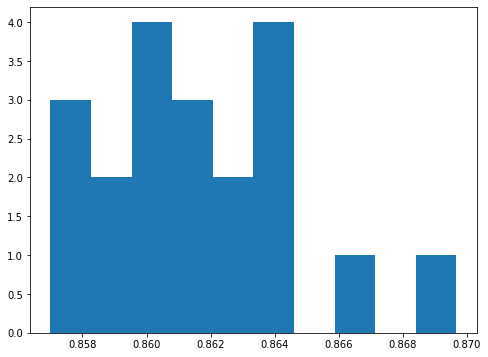

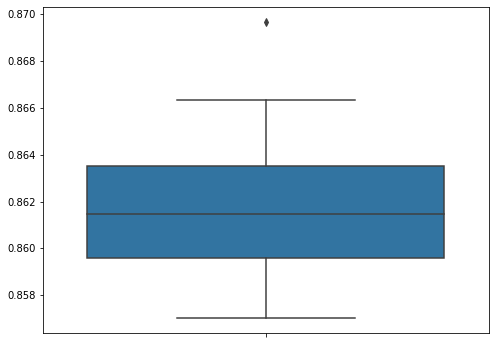

In [ ]:
#cross_validation_prediction(rf_model, X, y)
cross_validation_prediction(opt_rf_model, X, y)

### **Train Definition III**

* **Test 3)** In the third set of features, we used only the most important features pointed out in Test 1 regarding the Random Forest predictions. Some of these features were also highlighted and connected in the EDA step, such age, education and working hours per week. 

> **The idea in this test set is reduce the number of features but improving, or at least keeping, the same performance results.**

In [ ]:
features3=['fnlwgt', 'age', 'hours-per-week', 'education-num', 'capital-gain', 'capital-loss', 'marital-status_simple_ Never-married', 'relationship_simple_ Spouse']

X = train_data[features3]
y = train_data['income_ >50K']
display(X.head())
display(y.head())

,fnlwgt,age,hours-per-week,education-num,capital-gain,capital-loss,marital-status_simple_ Never-married,relationship_simple_ Spouse
0,-1.063611,0.030671,-0.035429,1.134739,0.148453,-0.21666,1,0
1,-1.008707,0.837109,-2.222153,1.134739,-0.145920,-0.21666,0,1
2,0.245079,-0.042642,-0.035429,-0.420060,-0.145920,-0.21666,0,0
3,0.425801,1.057047,-0.035429,-1.197459,-0.145920,-0.21666,0,1
4,1.408176,-0.775768,-0.035429,1.134739,-0.145920,-0.21666,0,1


0    0
1    0
2    0
3    0
4    0
Name: income_ >50K, dtype: uint8

### **Optimized Random Forest and Kfold**

> Train and validation of Test 3 via the cross validation procedure applied to the optimized Random Forest model.

> **The optimized Random Forest through cross validation achieved on Test 3:**
  * Accuracy | mean: 0.856866 | min: 0.850491 | max: 0.862548
  * Recall | mean: 0.602194 | min: 0.584402 | max: 0.623541
  * Precision | mean: 0.754018 | min: 0.721059 | max: 0.774026
  * F1 | mean: 0.669504 | min: 0.657431 | max: 0.686176

**The obtained results follow the previous tests in terms of accuracy but using fewer features.**

ML model prediction | Classification metric:
Accuracy: 0.8541948163616263
Recall: 0.5844022575679836
Precision: 0.7513192612137203
F1: 0.6574314574314575


ML model prediction | Classification metric:
Accuracy: 0.8616707616707616
Recall: 0.6195269250125818
Precision: 0.768894440974391
F1: 0.6861761426978817


ML model prediction | Classification metric:
Accuracy: 0.8544226044226044
Recall: 0.6005181347150259
Precision: 0.736808645899555
F1: 0.6617185269768769


ML model prediction | Classification metric:
Accuracy: 0.8588452088452089
Recall: 0.610126582278481
Precision: 0.7607323232323232
F1: 0.6771565046361337


ML model prediction | Classification metric:
Accuracy: 0.8625475985751136
Recall: 0.6057941024314537
Precision: 0.7663612565445026
F1: 0.6766830395839353


ML model prediction | Classification metric:
Accuracy: 0.855896805896806
Recall: 0.5979328165374677
Precision: 0.7454896907216495
F1: 0.6636076856897045


ML model prediction | Classification metric:
Accuracy: 0.85442260442

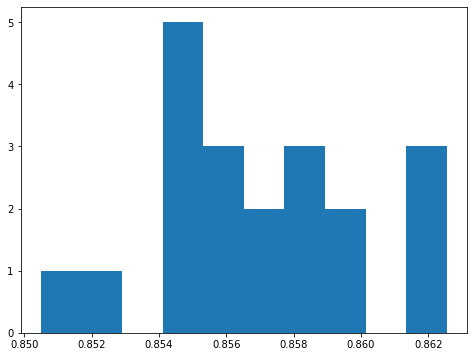

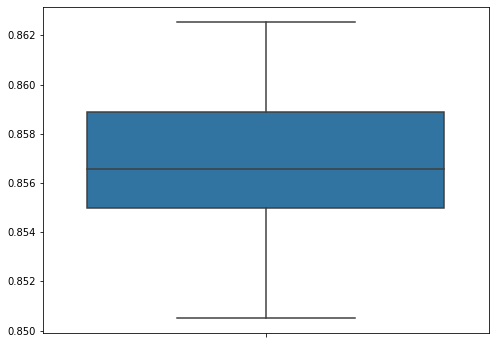

In [ ]:
#cross_validation_prediction(rf_model, X, y)
cross_validation_prediction(opt_rf_model, X, y)

### **Test step**

> Last prediction task over the test dataset using the feature set from Test 1 that obtained the best results, the optimized Random Forest and cross validation to evaluate the results.

> **The optimized Random Forest through cross validation achieved on the test dataset:**
  * Accuracy | mean: 0.856761 | min: 0.850983 | max: 0.862425
  * Recall | mean: 0.601938 | min: 0.582863 | max: 0.624556
  * Precision | mean: 0.753766 | min: 0.722565 | max: 0.775391
  * F1 | mean: 0.669238 | min: 0.655496 | max: 0.687117

We observe that the performance metrics of the model in both training and testing steps have followed similar results, which shows that our model could reach a reasonable trade-off between bias and variance. 

However, it's noted that further investigations regarding hyper parameter optimization (reaching the full potential of the algorithm) and also feature engineering (finding more elusive patterns) are needed to increase the method's performance. 

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,has_asset,sex_ Male,workclass_simple_ Federal-gov,workclass_simple_ Local-gov,workclass_simple_ Private,workclass_simple_ Self-emp-inc,workclass_simple_ Self-emp-not-inc,workclass_simple_ State-gov,workclass_simple_ WO_pay,occupation_simple_ Craft-repair,occupation_simple_ Exec-managerial,occupation_simple_ Farming-fishing,occupation_simple_ Handlers-cleaners,occupation_simple_ Machine-op-inspct,occupation_simple_ Other-service,occupation_simple_ Priv-house-serv,occupation_simple_ Prof-specialty,occupation_simple_ Protective-serv,occupation_simple_ Sales,occupation_simple_ Tech-support,occupation_simple_ Transport-moving,marital-status_simple_ Never-married,marital-status_simple_ No-spouse,relationship_simple_ Other-relative,relationship_simple_ Own-child,relationship_simple_ Spouse,relationship_simple_ Unmarried,race_simple_ White,native-country_simple_ America,native-country_simple_ Asia,native-country_simple_ Europe,native-country_simple_ United-States
0,-0.995706,0.350774,-1.197459,-0.145920,-0.21666,-0.035429,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,-0.042642,-0.947095,-0.420060,-0.145920,-0.21666,0.774468,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
2,-0.775768,1.394362,0.746039,-0.145920,-0.21666,-0.035429,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,0.397233,-0.279070,-0.031360,0.895083,-0.21666,-0.035429,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,-1.508894,-0.817458,-0.031360,-0.145920,-0.21666,-0.845327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,has_asset,sex_ Male,workclass_simple_ Federal-gov,workclass_simple_ Local-gov,workclass_simple_ Private,workclass_simple_ Self-emp-inc,workclass_simple_ Self-emp-not-inc,workclass_simple_ State-gov,workclass_simple_ WO_pay,occupation_simple_ Craft-repair,occupation_simple_ Exec-managerial,occupation_simple_ Farming-fishing,occupation_simple_ Handlers-cleaners,occupation_simple_ Machine-op-inspct,occupation_simple_ Other-service,occupation_simple_ Priv-house-serv,occupation_simple_ Prof-specialty,occupation_simple_ Protective-serv,occupation_simple_ Sales,occupation_simple_ Tech-support,occupation_simple_ Transport-moving,marital-status_simple_ Never-married,marital-status_simple_ No-spouse,relationship_simple_ Other-relative,relationship_simple_ Own-child,relationship_simple_ Spouse,relationship_simple_ Unmarried,race_simple_ White,native-country_simple_ America,native-country_simple_ Asia,native-country_simple_ Europe,native-country_simple_ United-States
0,-0.995706,0.350774,-1.197459,-0.145920,-0.21666,-0.035429,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,-0.042642,-0.947095,-0.420060,-0.145920,-0.21666,0.774468,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
2,-0.775768,1.394362,0.746039,-0.145920,-0.21666,-0.035429,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,0.397233,-0.279070,-0.031360,0.895083,-0.21666,-0.035429,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,-1.508894,-0.817458,-0.031360,-0.145920,-0.21666,-0.845327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1


ML model prediction | Classification metric:
Accuracy: 0.8539491462965237
Recall: 0.5828630066700872
Precision: 0.7513227513227513
F1: 0.6564576711932967


ML model prediction | Classification metric:
Accuracy: 0.8621621621621621
Recall: 0.6200301962757927
Precision: 0.7704815509693559
F1: 0.687116564417178


ML model prediction | Classification metric:
Accuracy: 0.8540540540540541
Recall: 0.5984455958549223
Precision: 0.7366071428571429
F1: 0.6603773584905661


ML model prediction | Classification metric:
Accuracy: 0.8584766584766584
Recall: 0.6075949367088608
Precision: 0.7609384908053266
F1: 0.6756756756756757


ML model prediction | Classification metric:
Accuracy: 0.8613192482496008
Recall: 0.6016554578375582
Precision: 0.764126149802891
F1: 0.6732272069464544


ML model prediction | Classification metric:
Accuracy: 0.8562653562653563
Recall: 0.5979328165374677
Precision: 0.7469335054874112
F1: 0.6641791044776119


ML model prediction | Classification metric:
Accuracy: 0.854176904

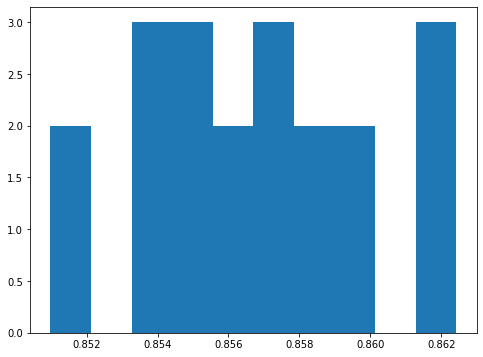

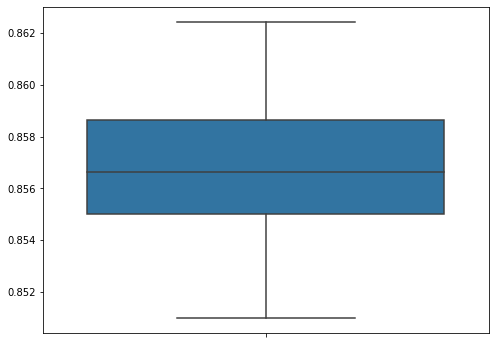

In [ ]:
X_test = test_data[features]
y_test = test_data['income_ >50K.']
display(X_test.head())
display(X_test.head())

#cross_validation_prediction(rf_model, X, y)
cross_validation_prediction(opt_rf_model, X, y)

# **Final remarks**

> To conclude the project, we can state that it is possible to determine whether a person makes over $\$50K$ a year based on census data, with a reasonable accuracy of $\approx$86% in the testing step.
However, there are features that are more relevant than others, such as age, working hours-per-week, education level, and these should be better considered in order to increase the accuracy of the models.

> Furthermore, as already mentioned, it is necessary that more specialized adjustments are done to improve the predictions' quality. For instance, it is possible to carry out further investigations on feature engineering and selection to better understand the target's behavior, and also focus on optimization of models' hyper parameters in order to extract the full potential of them.